In [1]:
import numpy as np
import pandas as pd 
import warnings
import pickle
import scipy


import matplotlib.pyplot as plt
# import option_pricing as pricing

import scipy.stats as stats

from scipy.stats import norm, lognorm, t
from numpy.random import default_rng

from pandas.plotting import autocorrelation_plot
from scipy.stats import norm, probplot
from scipy.optimize import minimize

from tools_qfb import compare_histogram_pdf, qqplot
from my_time_series import (
    simulate_AR,
    residuals_AR,
    fit_AR_LS,
    fit_AR_ML_gaussian_noise,
    fit_AR_ML_student_t_noise,
    simulate_ARMA_GARCH,
    residuals_ARMA_GARCH, 
    fit_AR_GARCH_ML_gaussian_noise,
    fit_AR_GARCH_ML_student_t_noise,
    tests_gaussian_white_noise, 
    t_transient,
    test_t_student_noise,
    fit_AR_GARCH_ML_student_t_noise,
    arma_garch_t_noise,
    f_test
)
from trajectories import fancy_plot

from model_calibration import fit_pdf_ML
from datetime import datetime
from datetime import timedelta

eps_vol = lambda nu: np.sqrt(nu / (nu - 2)) ## vol = sqrt(h) * vol

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def index_from_str_to_dt(df, date_type: str):
    dates = df.index.values
    new_dates = np.empty_like(dates)

    for i,date in enumerate(dates):
        try:
            new_dates[i] = datetime.strptime(date, f'{date_type}/%Y')
            continue
        except ValueError:
            pass
        
        try:
            new_dates[i] = datetime.strptime(date, f'{date_type}/%y')
            continue
        except ValueError:
            pass

        warnings.warn(f'Non accepted format in {date}')
        break
        

    df['Datetime'] = new_dates
    df = df.set_index('Datetime')
    
    return df

In [3]:
###### Data Cleaning ######


data = pd.read_csv('Data/data.csv',index_col='Date')
data = data.iloc[1501:, :]
data = data.rename(columns= {"Index1": "PJM_swap_1m",
#                             "Index2" :  ,
#                             "Index3" : ,
#                             "Index4" : 
                            })
data = data.drop(['Index2', 'Index3', 'Index4'], axis = 1)

data_gas = pd.read_csv('Data/data_gas.csv', index_col = 'Date')
data_gas = data_gas.iloc[::-1]
data_gas = data_gas.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
data_gas = data_gas.rename(columns = {'Price': 'Gas_EU'})

data_sp = pd.read_csv('Data/data_sp.csv', index_col = 'Date')
data_sp = data_sp.iloc[::-1]
data_sp = data_sp.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
data_sp = data_sp.rename(columns={"Price": "SP500"})
data_sp["SP500"] = data_sp["SP500"].str.replace(',', '')
data_sp["SP500"] = pd.to_numeric(data_sp["SP500"])

data_ger_f = pd.read_csv('Data/data_ger_futures.csv',index_col = 'Date')
data_ger_f = data_ger_f.rename(columns = {'Value 1m': 'Ger_fw_1m' })

data_ger_1y = pd.read_csv('Data/data_ger_1y.csv',index_col = 'Date')
data_ger_1y = data_ger_1y.rename(columns = {'Value 1Y': 'Ger_fw_1y'})

data_gas_us = pd.read_csv('Data/data_gas_us.csv', index_col = 'Date')
data_gas_us = data_gas_us.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
data_gas_us = data_gas_us.rename(columns={"Price": "Gas_US"})
data_gas_us['Gas_US'] = data_gas_us['Gas_US'] * 10000 / 2930

data_ep_tx = pd.read_csv('Data/day_ahead_houston.csv')
data_ep_tx = data_ep_tx[data_ep_tx.zone == 'LZ_HOUSTON']
data_ep_tx = data_ep_tx.drop(['zone'], axis = 1)
data_ep_tx['Date'] = data_ep_tx['Date'].apply(lambda x: x.split(' ')[0])
data_ep_tx = data_ep_tx.groupby('Date').mean()
data_ep_tx = data_ep_tx.rename(columns={"price": "Tx_1d"})

data_ep_was = pd.read_csv('Data/day_ahead_was.csv')
data_ep_was = data_ep_was[data_ep_was.node_name == 'PEPCO ZONE']
data_ep_was = data_ep_was.drop(['node_name'], axis = 1)
data_ep_was['Date'] = data_ep_was['Date'].apply(lambda x: x.split(' ')[0])
data_ep_was = data_ep_was.groupby('Date').mean()
data_ep_was = data_ep_was.rename(columns={"total_lmp": "Was_1d"})

data_eex_qt = pd.read_csv('Data/eex_data_qt.csv')
data_eex_qt['Exchange Date'] = data_eex_qt['Exchange Date'].apply(lambda x: x.replace('-','/'))
data_eex_qt = data_eex_qt.set_index(data_eex_qt['Exchange Date'])
data_eex_qt = data_eex_qt.drop(['Exchange Date'], axis = 1)
data_eex_qt = data_eex_qt.rename(columns={"Close": "eex_qt"})


data        = index_from_str_to_dt(data       , '%d/%m')
data_gas    = index_from_str_to_dt(data_gas   , '%m/%d')
data_sp     = index_from_str_to_dt(data_sp    , '%m/%d')
data_ger_f  = index_from_str_to_dt(data_ger_f , '%d/%m')
data_ger_1y = index_from_str_to_dt(data_ger_1y, '%m/%d')
data_gas_us = index_from_str_to_dt(data_gas_us, '%m/%d')
data_ep_tx  = index_from_str_to_dt(data_ep_tx , '%m/%d')
data_ep_was = index_from_str_to_dt(data_ep_was, '%m/%d')
data_eex_qt = index_from_str_to_dt(data_eex_qt, '%d/%b')


data = pd.merge(data, data_gas   , left_index=True, right_index=True)
data = pd.merge(data, data_sp    , left_index=True, right_index=True)
data = pd.merge(data, data_ger_f , left_index=True, right_index=True)
data = pd.merge(data, data_ger_1y, left_index=True, right_index=True)
data = pd.merge(data, data_gas_us, left_index=True, right_index=True)
data = pd.merge(data, data_ep_tx , left_index=True, right_index=True)
data = pd.merge(data, data_ep_was, left_index=True, right_index=True)
data = pd.merge(data, data_eex_qt, left_index=True, right_index=True)


date_f = pd.to_datetime(pd.DataFrame(data.index.values,columns=['col1']).col1).dt.to_period('m')

data_eu = pd.read_csv('Data/dayahead_europa.csv', delimiter=';')
data_eu['datetime'] = data_eu['datetime'].apply(lambda x:x[:10])

data_esp = data_eu[data_eu['name'] == 'Marginal price Day Ahead market Spain']
data_esp = data_esp.copy()
data_esp['datetime'] = data_esp['datetime'].apply(lambda x: x.replace('-', '/'))
data_esp['datetime'] = data_esp['datetime'].apply(lambda x: x[5:] + '/' + x[:4])
data_esp = data_esp.set_index(data_esp['datetime'])
data_esp = data_esp.drop(['name', 'id', 'geoid', 'geoname', 'datetime'], axis = 1)
data_esp = data_esp.rename(columns={"value": "spa_1d"})


data_ger = data_eu[data_eu['name'] == 'Marginal price Day Ahead market Germany']
data_ger = data_ger.copy()
data_ger['datetime'] = data_ger['datetime'].apply(lambda x: x.replace('-', '/'))
data_ger['datetime'] = data_ger['datetime'].apply(lambda x: x[5:] + '/' + x[:4])
data_ger = data_ger.set_index(data_ger['datetime'])
data_ger = data_ger.drop(['name', 'id', 'geoid', 'geoname', 'datetime'], axis = 1)
data_ger = data_ger.rename(columns={"value": "ger_1d"})


data_fr = data_eu[data_eu['name'] == 'Marginal price Day Ahead market France']
data_fr = data_fr.copy()
data_fr['datetime'] = data_fr['datetime'].apply(lambda x: x.replace('-', '/'))
data_fr['datetime'] = data_fr['datetime'].apply(lambda x: x[5:] + '/' + x[:4])
data_fr = data_fr.set_index(data_fr['datetime'])
data_fr = data_fr.drop(['name', 'id', 'geoid', 'geoname', 'datetime'], axis = 1)
data_fr = data_fr.rename(columns={"value": "fr_1d"})


data_esp = index_from_str_to_dt(data_esp , '%m/%d')
data_ger = index_from_str_to_dt(data_ger , '%m/%d')
data_fr  = index_from_str_to_dt(data_fr  , '%m/%d')

data_eu = pd.merge(data_esp, data_ger   , left_index=True, right_index=True)
data_eu = pd.merge(data_eu , data_fr    , left_index=True, right_index=True)

us_fut = pd.read_csv('Data/data_fut_us.csv')
us_fut['Exchange Date'] = us_fut['Exchange Date'].apply(lambda x: x.replace('-','/'))
us_fut = us_fut.set_index(us_fut['Exchange Date'])
us_fut = us_fut.drop(['Exchange Date'], axis = 1)
us_fut = us_fut.rename(columns={"Close": "us_fut"})

us_fut = index_from_str_to_dt(us_fut, '%d/%b')
us_fut = us_fut.sort_index()
us_fut['us_fut'] = us_fut['us_fut'].fillna(method='ffill')

data_fut_gas = pd.read_csv('Data/futures_eu_us_gas.csv')
data_fut_gas['date'] = data_fut_gas['date'].apply(lambda x: x.replace('-','/'))
data_fut_gas = data_fut_gas.set_index(data_fut_gas['date'])
data_fut_gas = data_fut_gas.drop(['date','us_vol', 'eu_vol'], axis = 1)
data_fut_gas = index_from_str_to_dt(data_fut_gas , '%d/%m')
data_fut_gas['us_fut'] = data_fut_gas['us_fut'] * 10000 / 2930
data_fut_gas = data_fut_gas.rename(columns={"us_fut": "us_fut_gas", "eu_fut": "eu_fut_gas"})

all_data = pd.merge(data_eu , data   , left_index=True, right_index=True)
all_data = pd.merge(all_data, us_fut , left_index=True, right_index=True)

data_garch = pd.merge(data[['PJM_swap_1m', 'Gas_EU', 'Gas_US', 'eex_qt', 'Ger_fw_1m', 'Ger_fw_1y']], us_fut, left_index=True,right_index=True)
data_garch = pd.merge(data_garch, data_fut_gas,left_index=True,right_index=True)

###### Exchange rate ######

fx_eu_per_usd = pd.read_csv('data_christina/fx_usd_eur.csv')
fx_eu_per_usd = fx_eu_per_usd[['Date', 'Close']].iloc[1:,:] ## Dropping first row to match time series with utilities
fx_eu_per_usd = fx_eu_per_usd.rename(columns = {'Close': 'fx'})
fx_eu_per_usd['Date'] = fx_eu_per_usd.Date.apply(lambda date: datetime.strptime(date, f'%Y-%m-%d'))
fx_eu_per_usd = fx_eu_per_usd.set_index('Date')

european_variables = ['spa_1d', 'get_1d', 'fr_1d', 'Gas_EU', 'Ger_fw_1m', 'Ger_fw_1y', 'eex_qt', 'eu_fut_gas' ]
datasets           = [all_data, data, data_garch]

for dataset in datasets:
    for variable in european_variables:
        if variable not in dataset.keys():
            continue
        dataset[variable] = dataset[variable].div(fx_eu_per_usd.loc[dataset.index.values,'fx'],axis = 0)

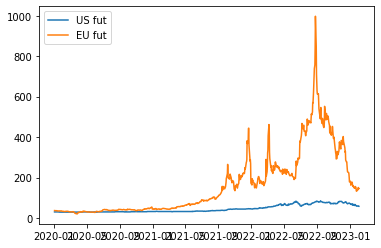

In [5]:
plt.plot(data_garch['us_fut'],label = 'US fut')
plt.plot(data_garch['eex_qt'],label = 'EU fut')
plt.legend()
plt.show()

### Garch fitting

Maximum likelihood estimates:
0.0983 [-0.3285] 0.2817 [0.0533] [0.8804] 3.2298

Maximum likelihood estimates:
0.2612 [0.0973] 0.6129 [0.1129] [0.8247] 6.2051

Maximum likelihood estimates:
0.1585 [-0.0315] 0.0889 [0.0584] [0.9202] 7.1881

Maximum likelihood estimates:
0.0715 [0.1028] 0.192 [0.0763] [0.8483] 3.7173

Maximum likelihood estimates:
0.0517 [0.0657] 0.1538 [0.0402] [0.9071] 3.1625

Maximum likelihood estimates:
0.2169 [0.0622] 0.222 [0.1896] [0.7557] 9.6121

Maximum likelihood estimates:
0.2405 [0.1186] 0.4158 [0.1442] [0.7377] 9.1501



/home/ignacio/Documents/ICADE/paper_christina/my_time_series.py:546: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)


Maximum likelihood estimates:
0.1846 [-0.0364] 0.1347 [0.0709] [0.8984] 6.379

Maximum likelihood estimates:
0.3019 [0.0349] 0.7308 [0.1282] [0.8074] 6.7785



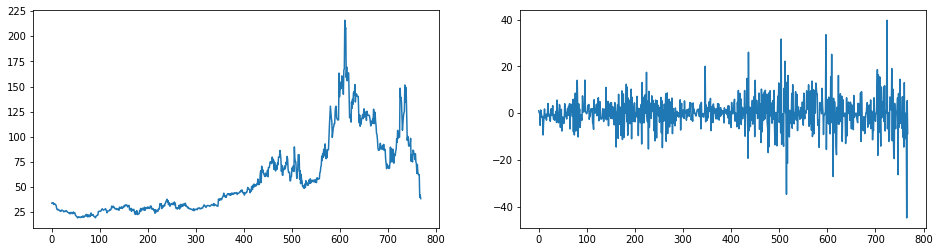

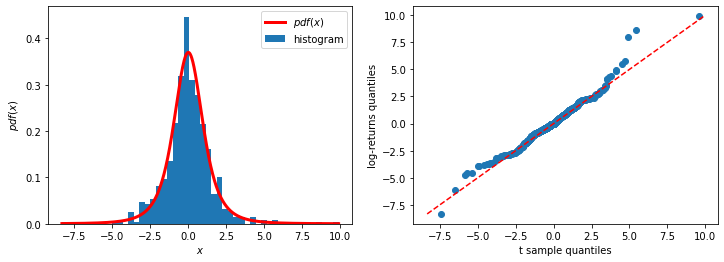

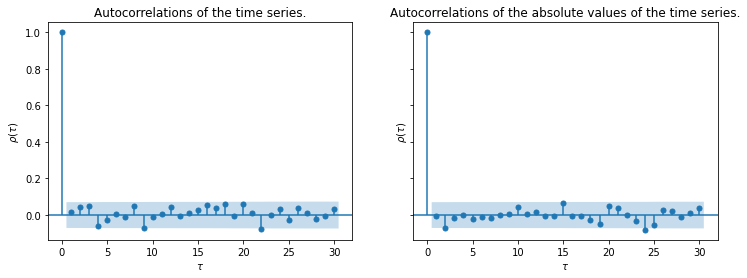

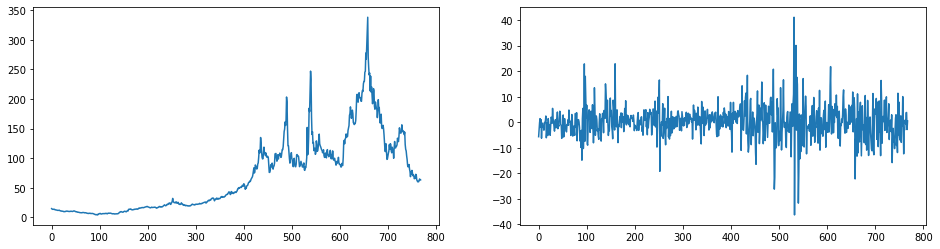

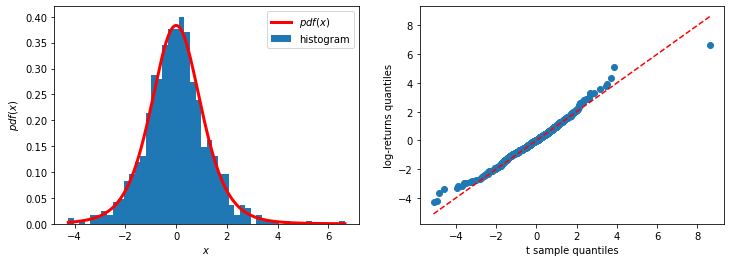

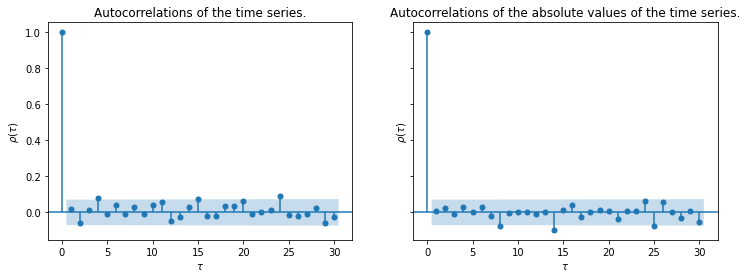

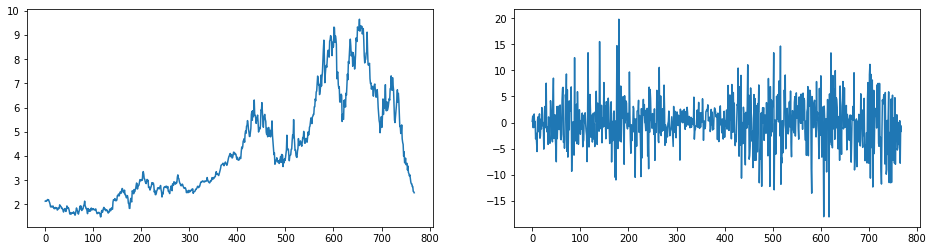

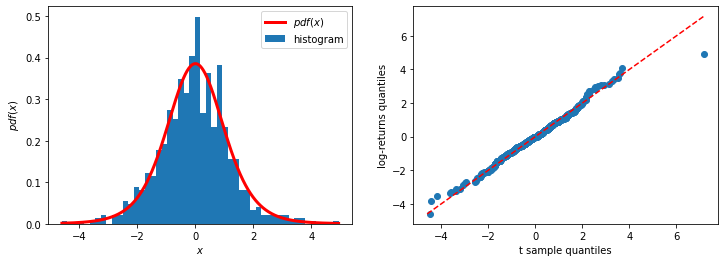

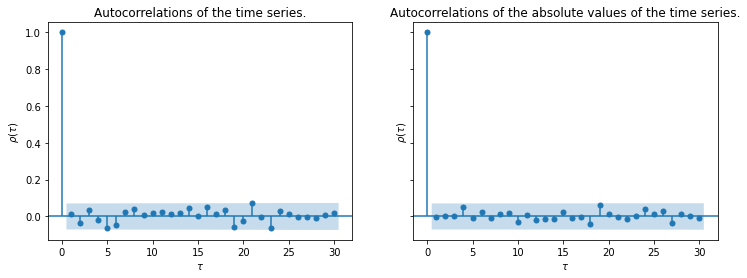

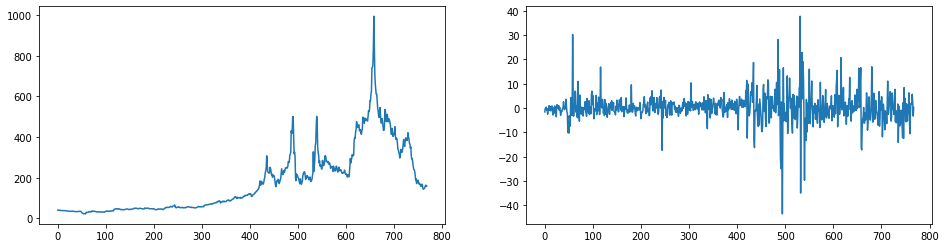

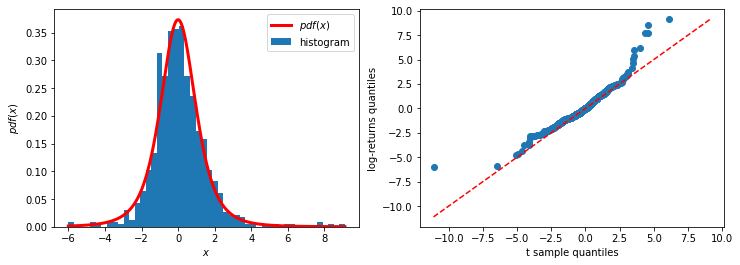

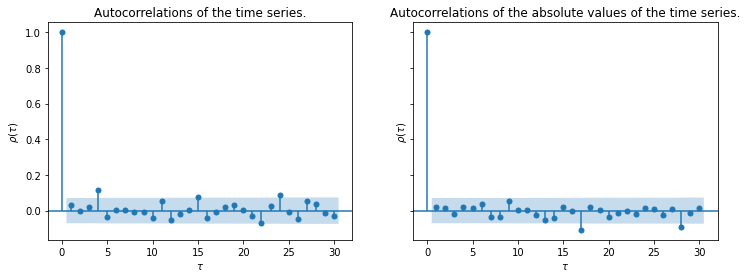

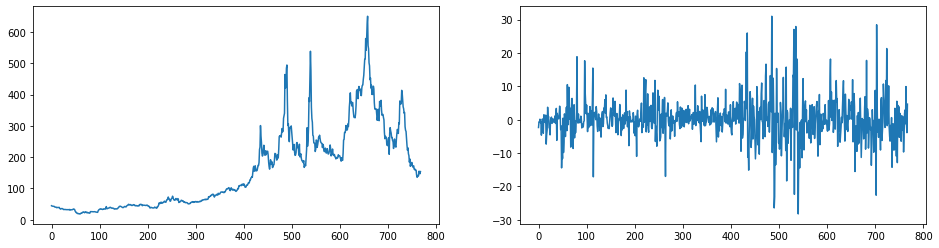

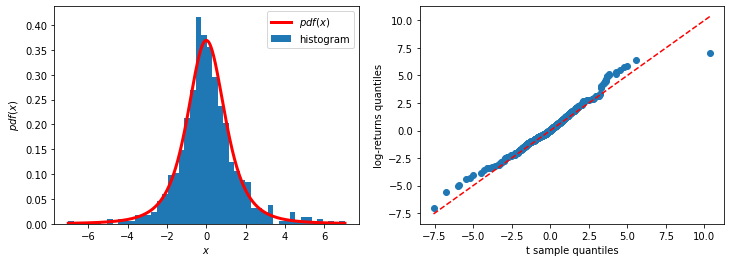

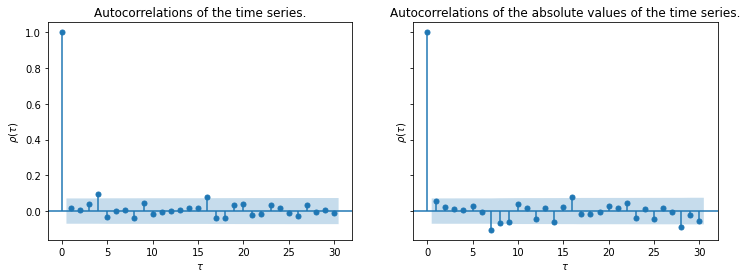

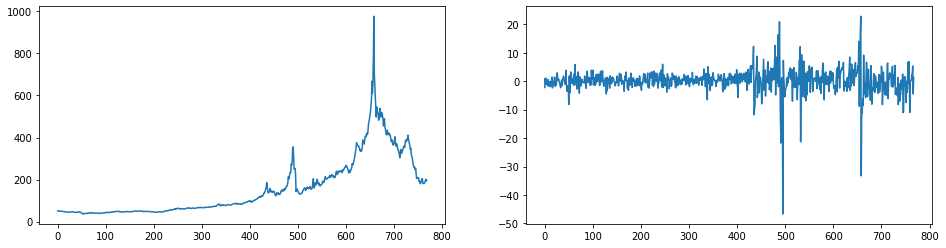

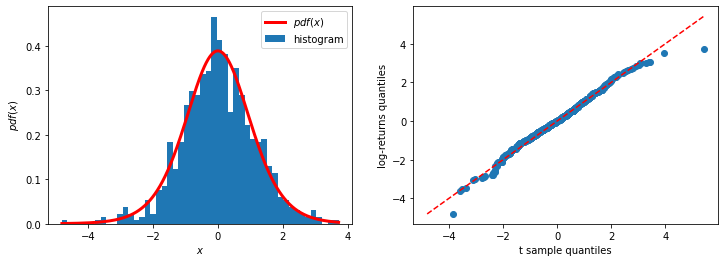

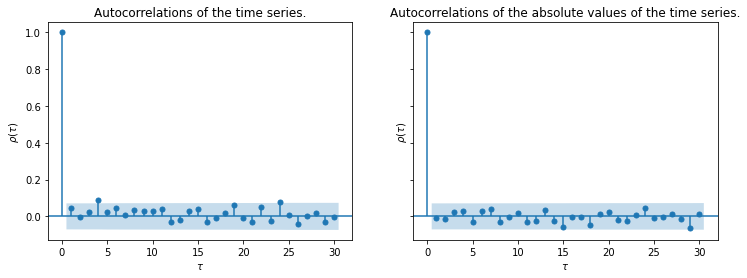

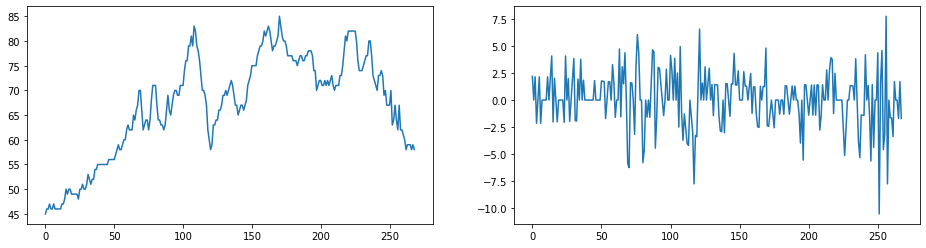

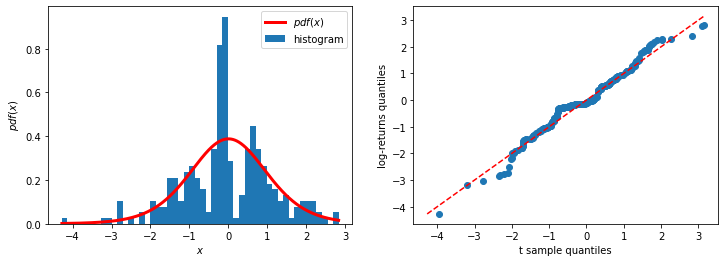

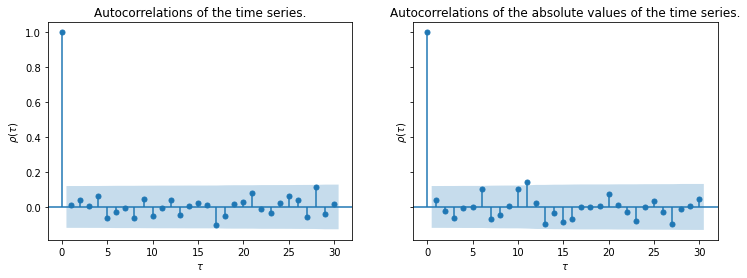

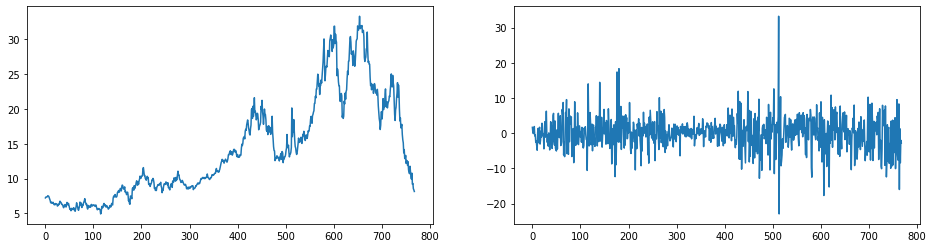

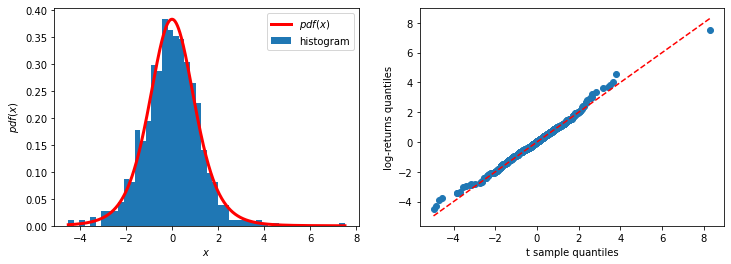

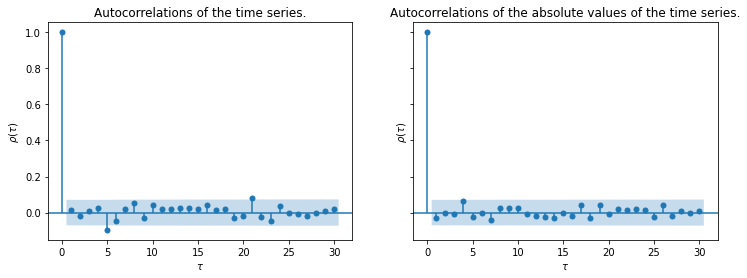

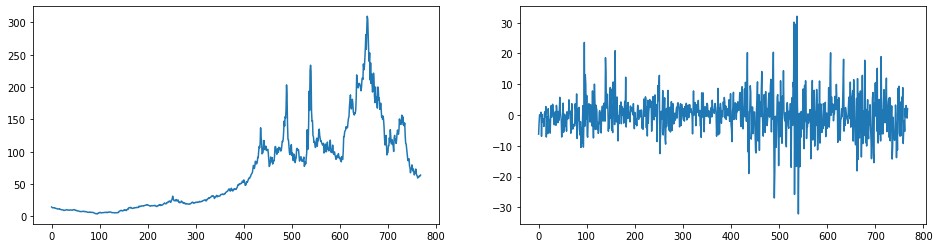

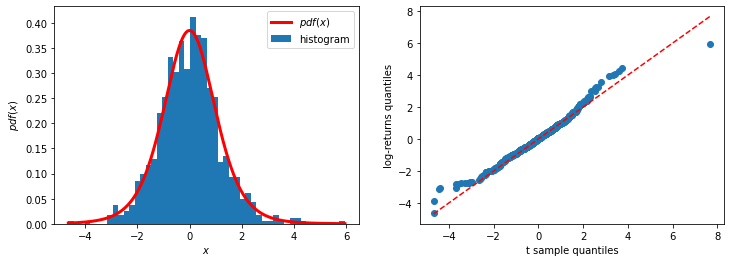

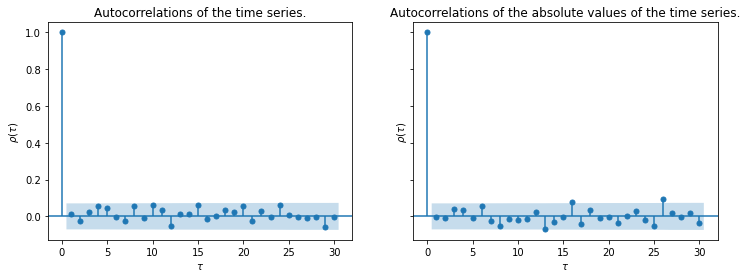

In [4]:
## For the US FUTURES we only use the last part of the sample because in the early part the value is almost constant thus the returns are mostly 0 and the fit is impossible.


results = {}

for key in data_garch.keys():
    
    if key == 'us_fut':
        prices = data_garch[key].values[500:]
    else:
        prices = data_garch[key].values
        

    phi_0, phi= 0.2, [0.1]
    theta = []
    kappa = 0.1
    alpha = [0.05]
    beta = [0.90]
    p = len(phi)
    q = len(theta)
    r = len(alpha) 
    s = len(beta)
    delay = max(p, q, r, s)
    nu = 5
    
    params, u, h = arma_garch_t_noise(prices,phi_0, phi, theta, kappa, alpha, beta, nu)
    
    results[key] = [params, u , h]
    

with open('fitted_models.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)


### First plots and tables

In [ ]:
plt.plot(data_fut_gas['us_vol'], label = 'us')
plt.plot(data_fut_gas['eu_vol'], label = 'eu')
plt.xticks(rotation = 70)
plt.axvline(x = data_garch.index.values[500], color = 'red', linestyle="--", label = 'Gas Crisis')
plt.legend()
plt.show()

KeyError: 'us_vol'

In [295]:
data_garch

,PJM_swap_1m,Gas_EU,Gas_US,eex_qt,Ger_fw_1m,Ger_fw_1y,us_fut,us_fut_gas,eu_fut_gas
Datetime,,,,,,,,,
2020-01-03,34.10,14.506111,7.269625,40.943316,44.909176,50.718323,30.0,7.215017,14.578725
2020-01-06,34.45,13.706887,7.286689,40.294676,43.866503,49.614912,30.0,7.334471,13.701306
2020-01-07,34.50,13.359208,7.378840,40.212000,43.560201,50.111028,30.0,7.351536,13.381604
2020-01-08,34.50,13.346645,7.307167,40.056666,43.224612,49.527039,30.0,7.341297,13.385686
2020-01-09,32.75,13.535890,7.392491,40.218708,43.285954,50.065012,30.0,7.392491,13.335852
...,...,...,...,...,...,...,...,...,...
2023-01-30,62.52,59.962602,9.320819,150.884937,140.513568,185.901896,59.0,9.174061,60.336580
2023-01-31,62.52,62.228733,9.354949,159.711372,155.164931,190.972222,59.0,9.290102,62.230903
2023-02-01,39.95,64.649789,8.655290,163.609310,152.867833,201.470572,58.0,8.539249,63.210713


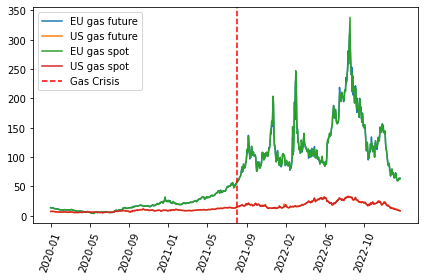

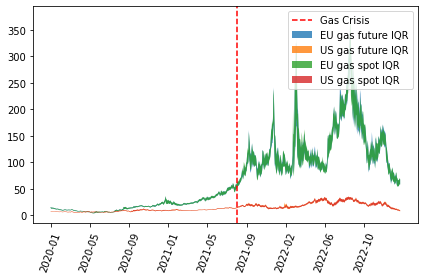

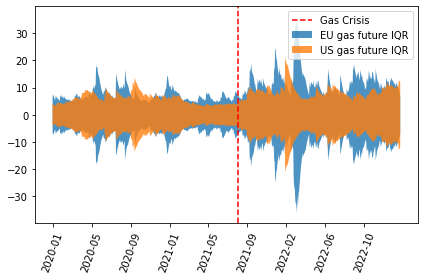

In [294]:
rolling_delay = 30
date_f = pd.to_datetime(pd.DataFrame(data_garch.index.values,columns=['col1']).col1).dt.to_period('m')

for ploting, name in enumerate(['Figures/levels.pdf', 'Figures/levels_bands.pdf', 'Figures/returns_bands.pdf']):
    for serie in ['eu_fut_gas', 'us_fut_gas', 'Gas_EU', 'Gas_US']:
        u  = results[serie][1]
        h  = results[serie][2]
        df = results[serie][0][-1]
        x  = range(len(h))

        prices = data_garch[serie].values
        x = range(len(prices) - 1)
        labels = data_garch[serie].index.values

        innovation_top = t.ppf(0.95, df = df, scale = np.sqrt(h) )
        innovation_bot = t.ppf(0.05, df = df, scale = np.sqrt(h) )

        prices_top = prices[:-1] * np.exp(innovation_top / 100)
        prices_bot = prices[:-1] * np.exp(innovation_bot / 100)
        
    
        plt.xticks(x, date_f[1:], rotation = 70)
        plt.locator_params(axis='x', nbins=9)
    
        if serie == 'eu_fut_gas':
            label = 'EU gas future'
        if serie == 'us_fut_gas':
            label = 'US gas future'
        if serie == 'Gas_EU':
            label = 'EU gas spot'
        if serie == 'Gas_US':
            label = 'US gas spot'

        if ploting == 0:
            plt.plot(x, prices[1:], label = label)
        
        if ploting == 1:
            plt.fill_between(x, prices_top, prices_bot, where= prices_top >= prices_bot, interpolate=True, alpha = 0.8, label = f'{label} IQR')
            
        if serie == 'Gas_EU':
            continue
        if serie == 'Gas_US':
            continue
            
        if ploting == 2:
            plt.fill_between(x, innovation_top, innovation_bot, where= innovation_top >= innovation_bot, interpolate=True, alpha = 0.8, label = f'{label} IQR')
    
    plt.axvline(x = 410, color = 'red', linestyle="--", label = 'Gas Crisis')
    plt.legend()
    plt.tight_layout()
    plt.savefig(name)
    plt.show()


[]

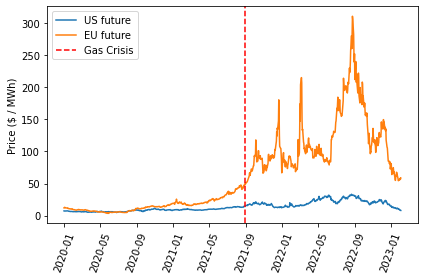

In [11]:
first_jan = data_fut_gas.index.values[351]
thirtyone_aug = data_fut_gas.index.values[785]

plt.plot(data_fut_gas['us_fut_gas'][first_jan:],label = 'US future')
plt.plot(data_fut_gas['eu_fut_gas'][first_jan:],label = 'EU future')
plt.xticks(rotation = 70)
plt.axvline(x = thirtyone_aug, color = 'red', linestyle="--", label = 'Gas Crisis')
plt.legend()
plt.ylabel('Price ($ / MWh)')
plt.tight_layout()
plt.savefig('Figures/month_gas_comp.pdf')
plt.plot()

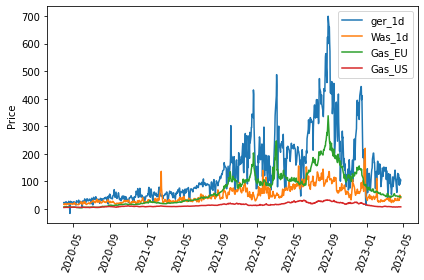

In [13]:
variables = ['ger_1d', 'Was_1d', 'Gas_EU', 'Gas_US']

for var in variables:
    std_data = (all_data[var] - np.mean(all_data[var])) / np.std(all_data[var])
    plt.plot(all_data[var], label = var)
    
plt.xticks(rotation = 70)
plt.legend()
plt.ylabel('Price')
plt.tight_layout()
plt.savefig('Figures/ger_vs_was_vs_gas_vs_gas.pdf')
plt.show()

In [232]:
log_data       = 100 * np.log(all_data).diff()
log_summ_stats = log_data[:680].agg([ "mean","std", "median"]).transpose()
log_summ_stats['mean'] = log_summ_stats['mean']  * 252
log_summ_stats['std']  = log_summ_stats['std']   * np.sqrt(252)
print(log_summ_stats.apply(lambda x: np.round(x,2)).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &   mean &     std &  median \\
\midrule
spa\_1d      &  -7.37 &  339.17 &    0.66 \\
ger\_1d      &  33.61 &  481.65 &    0.02 \\
fr\_1d       &  73.10 &  324.48 &    0.73 \\
PJM\_swap\_1m &  59.31 &  108.73 &    0.00 \\
Gas\_EU      &  91.25 &  106.11 &    0.49 \\
SP500       &  16.42 &   20.35 &    0.10 \\
Ger\_fw\_1m   &  87.63 &   99.00 &    0.02 \\
Ger\_fw\_1y   &  70.93 &   68.69 &    0.31 \\
Gas\_US      &  42.44 &   72.82 &    0.26 \\
Tx\_1d       &  99.06 &  609.76 &   -0.17 \\
Was\_1d      &  82.69 &  275.43 &    0.43 \\
eex\_qt      &  77.91 &   92.96 &    0.14 \\
us\_fut      &  32.70 &   25.07 &    0.00 \\
\bottomrule
\end{tabular}



In [8]:
summ_stats = all_data[:683].agg([ "mean","std", "min", "max", "median", "skew"]).transpose()

In [9]:
print(summ_stats.apply(lambda x: np.round(x,2)).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &     mean &     std &      min &      max &   median &   skew \\
\midrule
spa\_1d      &   115.68 &   79.33 &     7.10 &   544.98 &    98.72 &   0.96 \\
ger\_1d      &   142.20 &  128.63 &   -16.15 &   699.44 &    89.73 &   1.46 \\
fr\_1d       &   161.16 &  144.94 &     4.18 &   743.84 &    92.12 &   1.30 \\
PJM\_swap\_1m &    60.30 &   38.23 &    19.55 &   215.86 &    45.17 &   1.16 \\
Gas\_EU      &    68.63 &   63.57 &     3.51 &   339.20 &    45.28 &   1.09 \\
SP500       &  3940.40 &  501.09 &  2470.50 &  4796.56 &  3965.34 &  -0.51 \\
Ger\_fw\_1m   &   153.28 &  129.48 &    19.00 &   652.00 &    94.35 &   1.00 \\
Ger\_fw\_1y   &   152.29 &  144.60 &    34.85 &   980.00 &    82.50 &   1.62 \\
Gas\_US      &     4.34 &    2.11 &     1.48 &     9.65 &     3.87 &   0.68 \\
Tx\_1d       &    89.87 &  563.22 &    12.49 &  8820.33 &    35.91 &  13.49 \\
Was\_1d      &    51.96 &   31.02 &    15.36 &   220.21 &    42.22 &   1.17 \\
eex\_qt      &   

In [10]:
list(all_data.keys())

['spa_1d',
 'ger_1d',
 'fr_1d',
 'PJM_swap_1m',
 'Gas_EU',
 'SP500',
 'Ger_fw_1m',
 'Ger_fw_1y',
 'Gas_US',
 'Tx_1d',
 'Was_1d',
 'eex_qt',
 'us_fut']

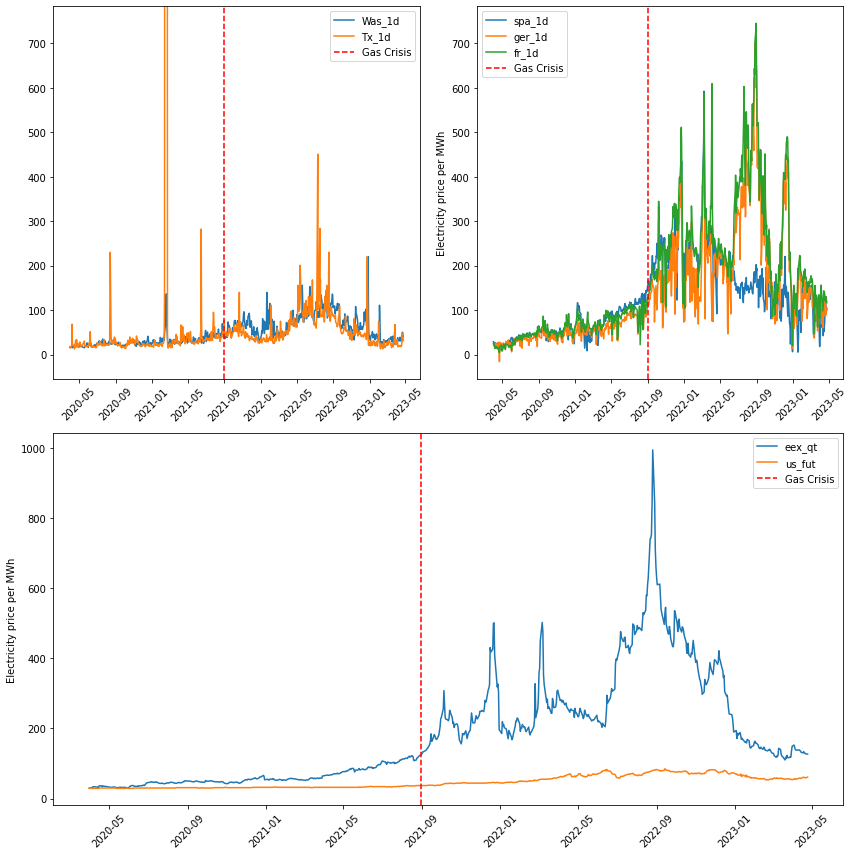

In [296]:
fig, ax = plt.subplots(2, 2,  figsize = (12, 12))

eu_vars = ['spa_1d', 'ger_1d', 'fr_1d']

us_vars = ['Was_1d', 'Tx_1d',]

fut_diff = [ 'eex_qt', 'us_fut']

gas_comp = ['Gas_EU', 'Gas_US' ]

gas_crisis = all_data.index.values[350]

xs = pd.to_datetime(pd.DataFrame(all_data.index.values,columns=['col1']).col1).dt.to_period('m')

ax3 = plt.subplot(212)
ax2 = plt.subplot(221)
ax1 = plt.subplot(222)

for var in eu_vars:
    ax1.plot( all_data[var]  , label = var)
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
    
for var in us_vars:
    ax2.plot( all_data[var]  , label = var)
    for tick in ax2.get_xticklabels():
        tick.set_rotation(45)
        
for var in fut_diff:
    ax3.plot( all_data[var]  , label = var)
    for tick in ax3.get_xticklabels():
        tick.set_rotation(45)

                
        
ax1.axvline(x = gas_crisis, color = 'red', linestyle="--", label = 'Gas Crisis')
ax1.legend()   
ax3.axvline(x = gas_crisis, color = 'red', linestyle="--", label = 'Gas Crisis')
ax3.legend()  
ax2.axvline(x = gas_crisis, color = 'red', linestyle="--", label = 'Gas Crisis')
ax2.legend()   


# ax[2,0].set_ylim(-200,200)
ax2.set_ylim(ax1.get_ylim())

ax1.set_ylabel('Electricity price per MWh')
ax3.set_ylabel('Electricity price per MWh')
    
plt.tight_layout()
plt.savefig('Figures/general_comparison.pdf')
plt.show()

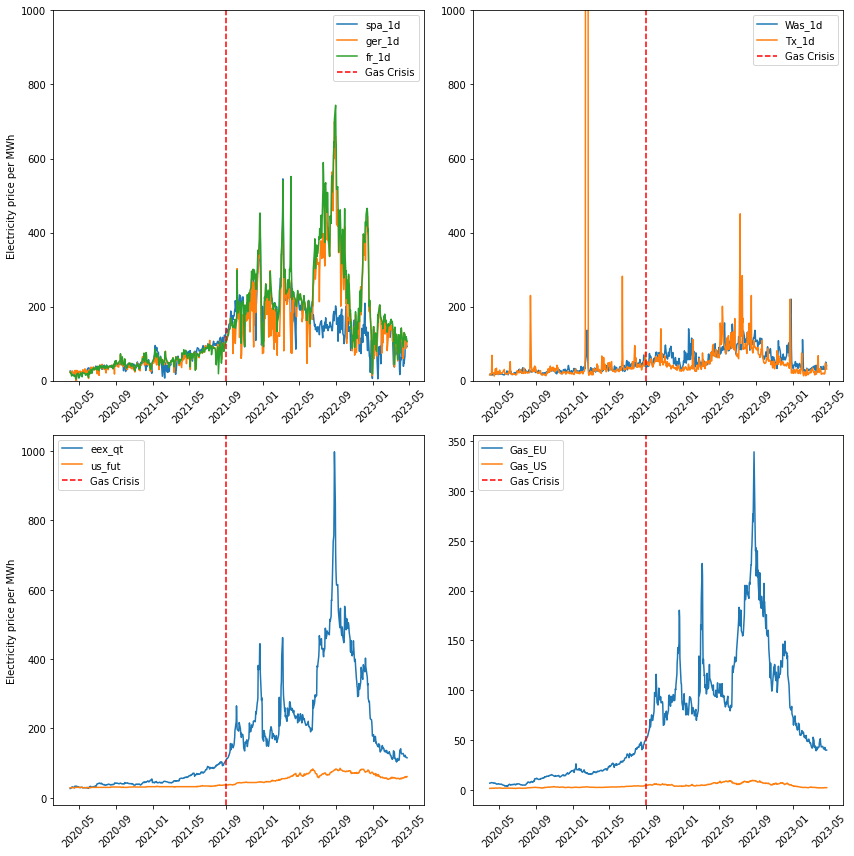

In [12]:
fig, ax = plt.subplots(2, 2,  figsize = (12, 12))

eu_vars = ['spa_1d', 'ger_1d', 'fr_1d']

us_vars = ['Was_1d', 'Tx_1d',]

fut_diff = [ 'eex_qt', 'us_fut']

gas_comp = ['Gas_EU', 'Gas_US' ]

gas_crisis = all_data.index.values[350]

xs = pd.to_datetime(pd.DataFrame(all_data.index.values,columns=['col1']).col1).dt.to_period('m')


for var in eu_vars:
    ax[0,0].plot( all_data[var]  , label = var)
    for tick in ax[0,0].get_xticklabels():
        tick.set_rotation(45)
    
for var in us_vars:
    ax[0,1].plot( all_data[var]  , label = var)
    for tick in ax[0,1].get_xticklabels():
        tick.set_rotation(45)
        
for var in fut_diff:
    ax[1,0].plot( all_data[var]  , label = var)
    for tick in ax[1,0].get_xticklabels():
        tick.set_rotation(45)
        
for var in gas_comp:
    ax[1,1].plot( all_data[var]  , label = var)
    for tick in ax[1,1].get_xticklabels():
        tick.set_rotation(45)
ax[0,0].set_ylim(0,1000)
                
        
ax[0,0].axvline(x = gas_crisis, color = 'red', linestyle="--", label = 'Gas Crisis')
ax[0,0].legend()   
ax[1,0].axvline(x = gas_crisis, color = 'red', linestyle="--", label = 'Gas Crisis')
ax[1,0].legend()  
ax[0,1].axvline(x = gas_crisis, color = 'red', linestyle="--", label = 'Gas Crisis')
ax[0,1].legend()   
ax[1,1].axvline(x = gas_crisis, color = 'red', linestyle="--", label = 'Gas Crisis')
ax[1,1].legend()

# ax[2,0].set_ylim(-200,200)
ax[0,1].set_ylim(ax[0,0].get_ylim())

ax[0,0].set_ylabel('Electricity price per MWh')
ax[1,0].set_ylabel('Electricity price per MWh')
    
plt.tight_layout()
plt.savefig('Figures/general_comparison.pdf')
plt.show()

In [14]:
break_data = 330

results_F = []

for var in log_data.keys():
    print(var)
    x = log_data[1:][var][np.logical_not(log_data[var].isnull())].values[:break_data]
    y = log_data[1:][var][np.logical_not(log_data[var].isnull())].values[break_data:]
    print(f_test(y , x))
    results_F.append(f_test(y , x))
    
results_F = pd.DataFrame(results_F, columns = ['F-score', 'p-value']).set_index(log_data.keys())

spa_1d
(1.9776535178490313, 7.10922432034522e-11)
ger_1d
(1.3136535145747912, 0.004621007984552117)
fr_1d
(1.4222131455150875, 0.00039567703549259203)
PJM_swap_1m
(2.9288154833611957, 1.1102230246251565e-16)
Gas_EU
(2.6384456918811288, 1.1102230246251565e-16)
SP500
(1.2109503426465424, 0.03353965881955134)
Ger_fw_1m
(3.3574565871886652, 1.1102230246251565e-16)
Ger_fw_1y
(9.919707432206446, 1.1102230246251565e-16)
Gas_US
(1.8708857181196759, 1.7505978888721074e-09)
Tx_1d
(0.3803600655480565, 1.0)
Was_1d
(1.7429673770945673, 7.434275517415045e-08)
eex_qt
(6.1940665580104355, 1.1102230246251565e-16)
us_fut
(5.106397321436981, 1.1102230246251565e-16)


In [15]:
print(results_F.apply(lambda x: np.round(x,2)).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  F-score &  p-value \\
\midrule
spa\_1d      &     1.98 &     0.00 \\
ger\_1d      &     1.31 &     0.00 \\
fr\_1d       &     1.42 &     0.00 \\
PJM\_swap\_1m &     2.93 &     0.00 \\
Gas\_EU      &     2.64 &     0.00 \\
SP500       &     1.21 &     0.03 \\
Ger\_fw\_1m   &     3.36 &     0.00 \\
Ger\_fw\_1y   &     9.92 &     0.00 \\
Gas\_US      &     1.87 &     0.00 \\
Tx\_1d       &     0.38 &     1.00 \\
Was\_1d      &     1.74 &     0.00 \\
eex\_qt      &     6.19 &     0.00 \\
us\_fut      &     5.11 &     0.00 \\
\bottomrule
\end{tabular}



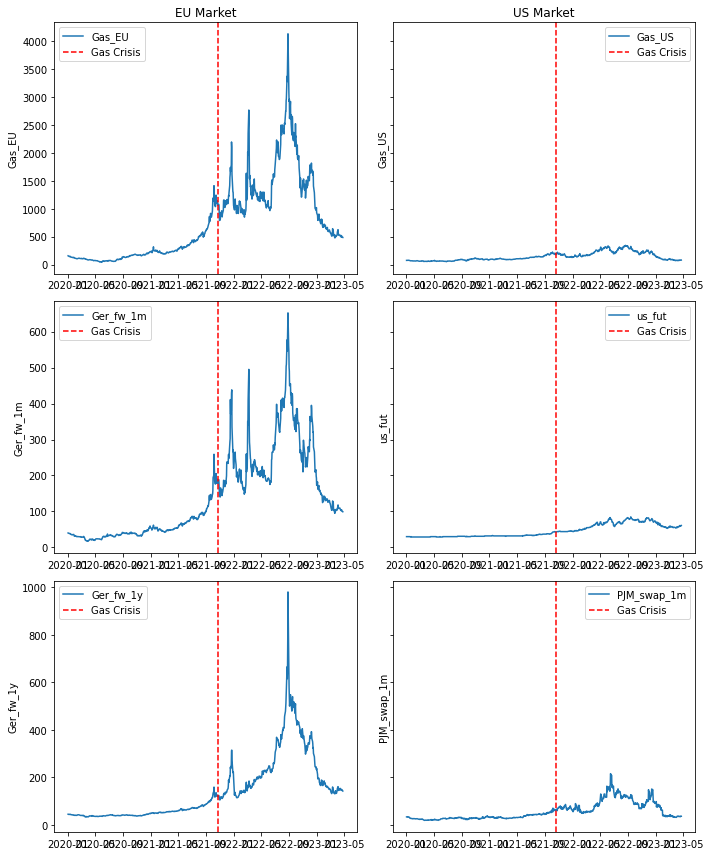

In [16]:
rows    = 3
columns = 2
 
fig, ax = plt.subplots(rows, columns, figsize = (10, 12), sharey = 'row')


variables  = np.array(['Gas_EU',
'Gas_US',
'Ger_fw_1m',
'us_fut',
'Ger_fw_1y',
'PJM_swap_1m'])

variables = variables.reshape(rows,columns)

gas_crisis = data.index.values[950]


for i in range(rows):
    for j in range(columns):
        if i == 0 and j == 0:
            ax[i,j].plot(data_garch[variables[i,j]] * 10.5*1.16  , label = variables[i,j])
        if i == 0 and j == 1:
            ax[i,j].plot(data_garch[variables[i,j]] * 35.8  , label = variables[i,j])
        if i != 0:
            ax[i,j].plot(data_garch[variables[i,j]], label = variables[i,j])    
        
        ax[i,j].axvline(x = gas_crisis, color = 'red', linestyle="--", label = 'Gas Crisis')
        ax[i,j].set_ylabel(variables[i,j])
        ax[i,j].legend()


ax[0,0].set_title('EU Market')
ax[0,1].set_title('US Market')
        
        
plt.tight_layout()
plt.savefig('Figures/prices_comparison.pdf')
plt.show()

### Empirical analysis

In [64]:
data_garch

,PJM_swap_1m,Gas_EU,Gas_US,eex_qt,Ger_fw_1m,Ger_fw_1y,us_fut,us_fut_gas,eu_fut_gas
Datetime,,,,,,,,,
2020-01-03,34.10,12.985,2.130,36.65,40.20,45.40,30.0,6.273928,13.050
2020-01-06,34.45,12.280,2.135,36.10,39.30,44.45,30.0,6.377801,12.275
2020-01-07,34.50,11.930,2.162,35.91,38.90,44.75,30.0,6.392640,11.950
2020-01-08,34.50,11.965,2.141,35.91,38.75,44.40,30.0,6.383736,12.000
2020-01-09,32.75,12.180,2.166,36.19,38.95,45.05,30.0,6.428253,12.000
...,...,...,...,...,...,...,...,...,...
2023-01-30,62.52,55.156,2.731,138.79,129.25,171.00,59.0,7.977445,55.500
2023-01-31,62.52,57.350,2.741,147.19,143.00,176.00,59.0,8.078350,57.352
2023-02-01,39.95,59.525,2.536,150.64,140.75,185.50,58.0,7.425434,58.200


In [4]:
with open('fitted_models.pickle', 'rb') as handle:
    results = pickle.load(handle)

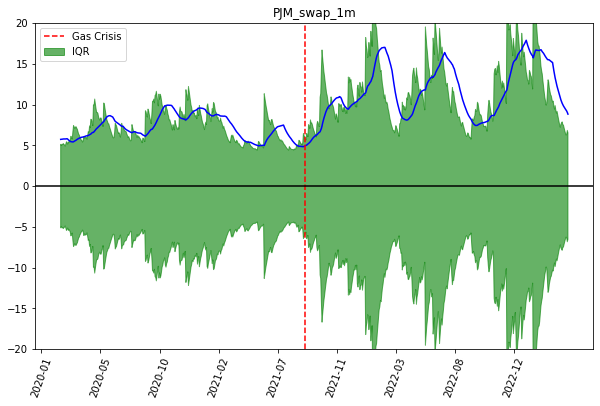

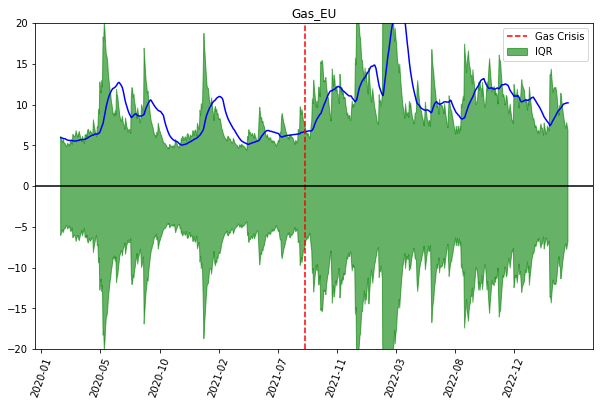

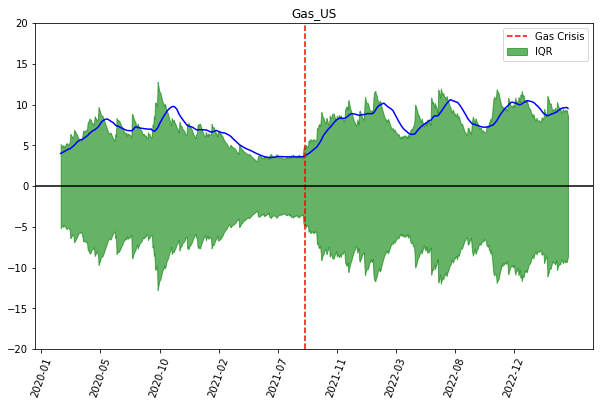

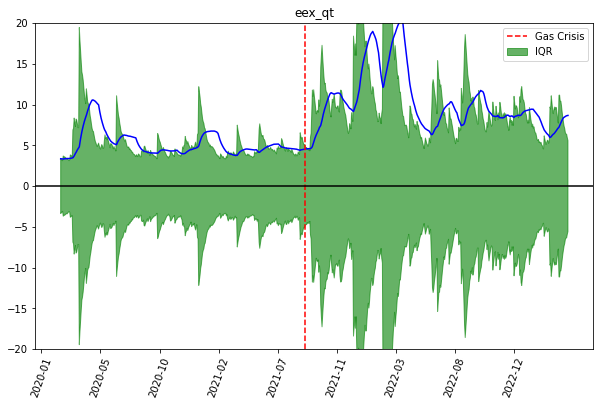

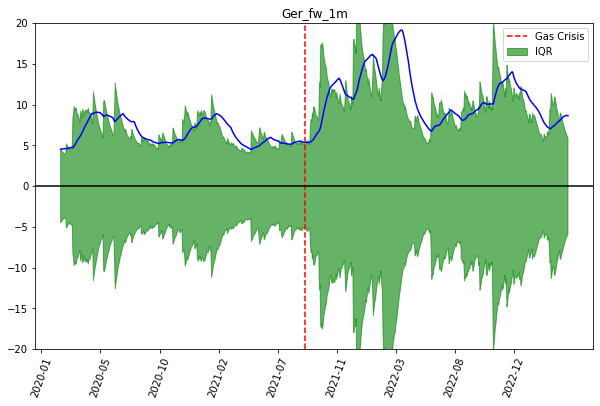

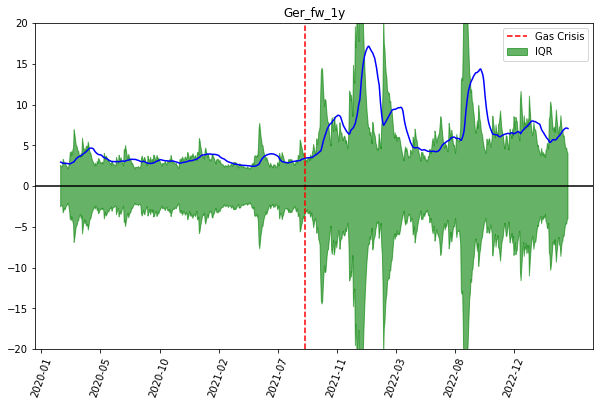

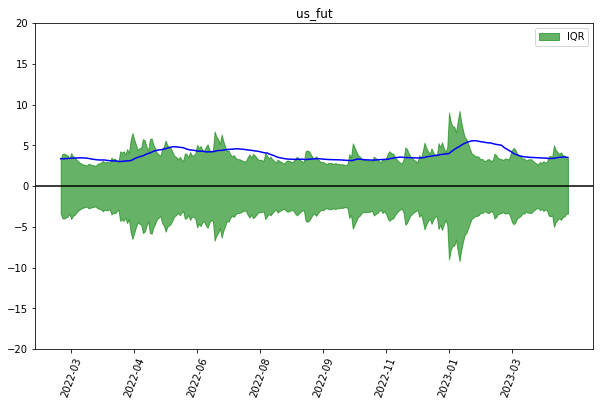

In [19]:
## Plotting stuff
rolling_delay = 30
# date_f = pd.to_datetime(pd.DataFrame(all_data.index.values,columns=['col1']).col1).dt.to_period('m')
date_f = pd.to_datetime(pd.DataFrame(data_garch.index.values,columns=['col1']).col1).dt.to_period('m')

for serie in data_garch.keys():
    
    u = results[serie][1]
    h = results[serie][2]
    df = results[serie][0][-1]
    x = range(len(h))
    plt.figure(figsize=(10,6))
    if serie == 'us_fut':
        plt.xticks(x, date_f[1+500:], rotation = 70)
    else:
        plt.xticks(x, date_f[1:], rotation = 70)
    plt.locator_params(axis='x', nbins=9)
    # plt.plot(x, np.sqrt(h) * eps_vol(df))
    top = t.ppf(0.95, df = df, scale = np.sqrt(h) )
    bot = t.ppf(0.05, df = df, scale = np.sqrt(h) )
    
    top_var = [np.mean(top[i-rolling_delay: i]) for i in range(rolling_delay, len(top))]
    
    plt.title(serie)
    plt.plot(x[rolling_delay:], top_var, color = 'blue')
    plt.fill_between(x[rolling_delay:], top[rolling_delay:], bot[rolling_delay:], where= top[rolling_delay:] >= bot[rolling_delay:], color='green', interpolate=True, alpha = 0.6, label = 'IQR')
#     plt.axvline(x = 595, color = 'orange', linestyle="--", label = 'Covid')
    if serie != 'us_fut':
        plt.axvline(x = 410, color = 'red', linestyle="--", label = 'Gas Crisis')
    plt.axhline(color = 'black')
    plt.ylim(-20,20)
    plt.legend()
    plt.show()

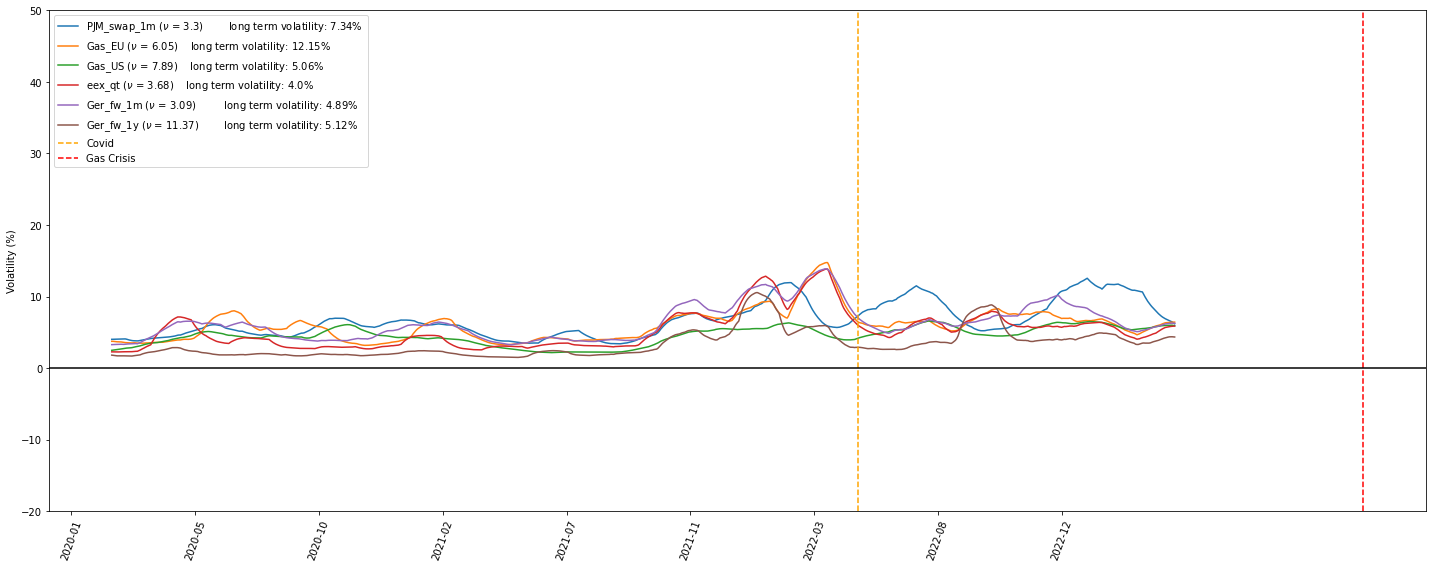

In [30]:
## Plotting stuff
rolling_delay = 30
plt.figure(figsize=(20,8))
plt.xticks(x, date_f[1:], rotation = 70)
plt.locator_params(axis='x', nbins=9)

for serie in data_garch.keys():
    
    if serie == 'us_fut':
        continue

    u = results[serie][1]
    h = results[serie][2]
    df = results[serie][0][-1]
    x = range(len(h))

#     plt.plot(x, np.sqrt(h) * eps_vol(df))
    
    top_var = [np.mean((np.sqrt(h) * eps_vol(df))[i-rolling_delay: i]) for i in range(rolling_delay, len(h))]
    
    kappa = results[serie][0][2]
    alpha = results[serie][0][3][0]
    beta  = results[serie][0][4][0]
    
    long_term_h = kappa / (1 - (alpha + beta))
    
    plt.plot(x[rolling_delay:], top_var, label = f'{serie} ($\\nu$ = {np.round(df,2)}) \t long term volatility: {np.round(long_term_h * eps_vol(df),2)}% ')
    
plt.axvline(x = 585, color = 'orange', linestyle="--", label = 'Covid')
plt.axvline(x = 960, color = 'red', linestyle="--", label = 'Gas Crisis')
plt.axhline(color = 'black')    
plt.ylim(-20,50)
plt.legend()
plt.ylabel('Volatility (%)')
plt.tight_layout()
plt.savefig('Figures/volatilities.pdf')
plt.show()

#### First simulations 

In [ ]:
with open('fitted_models.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [5]:
serie = 'eex_qt'
M = 10000
N = 250
crisis_idx = 410


u = results[serie][1]
h = results[serie][2]

phi0 = results[serie][0][0]
phi = results[serie][0][1]


random_shocks = np.random.randint(len(u) - crisis_idx, size=(M, N)) + crisis_idx
random_shocks = u[random_shocks]

simulation_eu = np.zeros([M,N + 1])
simulation_eu[:,0] = np.log(data_garch[serie][-1] / data_garch[serie][-2]) * 100

for step in range(1,N+1):
    
    simulation_eu[:,step] = phi0 + np.inner(phi,simulation_eu[:,step - 1].reshape((M,1))) + random_shocks[:, step - 1]
    

prices_simulation_eu = np.zeros([M,N + 1])
prices_simulation_eu[:,0] = data_garch[serie].values[-1]

for step in range(1,N+1):
    prices_simulation_eu[:,step] = prices_simulation_eu[:,step - 1] * np.exp(simulation_eu[:,step] / 100)

In [6]:
position = 'short' ## short means selling electricity.

M0        = 30000
M         = np.empty_like(prices_simulation_eu) 
M[:,0]    = 30000
T         = 22500
num_hours = 730
V0        = prices_simulation_eu[0,0] * num_hours * np.ones(prices_simulation_eu.shape[0])

paid_eu = np.zeros_like(prices_simulation_eu)
paid_eu[:,0] = M0

for idx, prices in enumerate(prices_simulation_eu.transpose()):
    if idx == 0:
        continue
        
    V = prices * num_hours
    
    if position == 'long':
        M[:, idx] = M[:,idx-1] + (V - V0)
        
    if position == 'short':
        M[:, idx] = M[:,idx-1] - (V - V0)
    
    condition              = M[:,idx] < T
    paid_eu[:,idx][condition] = M0 - M[:,idx][condition]
    M[:,idx][condition]    = M0
    
    if position == 'long':
        V0 = V0 - paid_eu[:,idx]
        
    if position == 'short':
        V0 = V0 + paid_eu[:,idx]

tot_paid_eu = np.cumsum(paid_eu, axis=1)

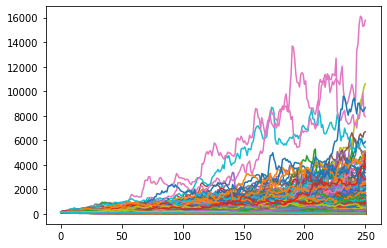

In [7]:
M = 1000
for i in range(M):
    plt.plot(prices_simulation_eu[i,:])
    
plt.show()

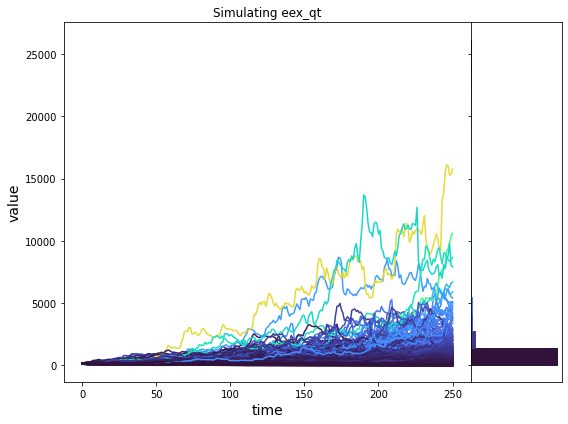

In [8]:
fancy_plot(prices_simulation_eu, n = prices_simulation_eu.shape[0], time_steps= prices_simulation_eu.shape[1] - 1, display = 1000,
                title = f'Simulating {serie}', savefig= True, figdir= 'Figures/simulation_process_eu.pdf')

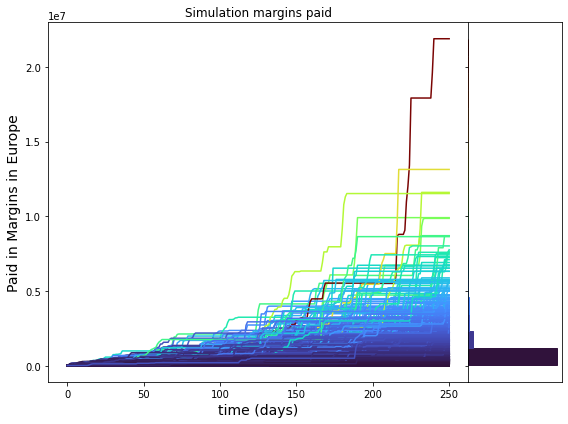

In [10]:
fancy_plot(tot_paid_eu, n = tot_paid_eu.shape[0], time_steps=tot_paid_eu.shape[1] - 1, display = tot_paid_eu.shape[0], xlabel = 'time (days)',
                 ylabel = 'Paid in Margins in Europe', savefig= True, figdir= 'Figures/simulation_margins_eu.pdf', title = 'Simulation margins paid')

In [36]:
data_garch_simulations = pd.DataFrame([prices_simulation_eu[:,-1],tot_paid_eu[:,-1]]).transpose()
data_garch_simulations = data_garch_simulations.rename(columns = {0: 'electricity_price', 1:'margins'})

stats_simulation_eu = data_garch_simulations.agg([ "mean","std", "min", "max", "median", "skew"]).transpose()
print(stats_simulation_eu.transpose().apply(lambda x: np.round(x,2)).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  electricity\_price &      margins \\
\midrule
mean   &             279.18 &    240594.03 \\
std    &             542.96 &    448368.60 \\
min    &               0.53 &     30000.00 \\
max    &           14222.63 &  10597467.57 \\
median &             124.30 &    105630.07 \\
skew   &               7.66 &         7.45 \\
\bottomrule
\end{tabular}



In [37]:
stats_simulation_eu

,mean,std,min,max,median,skew
electricity_price,279.177221,542.960800,0.533311,1.422263e+04,124.295922,7.655642
margins,240594.025067,448368.603586,30000.000000,1.059747e+07,105630.070040,7.445393


In [11]:
serie = 'us_fut'
M = 10000
N = 250
crisis_idx = 0


u = results[serie][1]
h = results[serie][2]

phi0 = results[serie][0][0]
phi = results[serie][0][1]


random_shocks = np.random.randint(len(u) - crisis_idx, size=(M, N)) + crisis_idx
random_shocks = u[random_shocks]

simulation_us = np.zeros([M,N + 1])
simulation_us[:,0] = np.log(data_garch[serie][-1] / data_garch[serie][-2]) * 100

for step in range(1,N+1):
    
    simulation_us[:,step] = phi0 + np.inner(phi,simulation_us[:,step - 1].reshape((M,1))) + random_shocks[:, step - 1]
    

prices_simulation_us = np.zeros([M,N + 1])
prices_simulation_us[:,0] = data_garch[serie].values[-1]

for step in range(1,N+1):
    prices_simulation_us[:,step] = prices_simulation_us[:,step - 1] * np.exp(simulation_us[:,step] / 100)

In [12]:
position = 'short' ## short means selling electricity.

M0        = 30000
M         = np.empty_like(prices_simulation_us) 
M[:,0]    = 30000
T         = 22500
num_hours = 730
V0        = prices_simulation_us[0,0] * num_hours * np.ones(prices_simulation_us.shape[0])

paid_us = np.zeros_like(prices_simulation_us)
paid_us[:,0] = M0

for idx, prices in enumerate(prices_simulation_us.transpose()):
    if idx == 0:
        continue
        
    V = prices * num_hours
    
    if position == 'long':
        M[:, idx] = M[:,idx-1] + (V - V0)
        
    if position == 'short':
        M[:, idx] = M[:,idx-1] - (V - V0)
    
    condition              = M[:,idx] < T
    paid_us[:,idx][condition] = M0 - M[:,idx][condition]
    M[:,idx][condition]    = M0
    
    if position == 'long':
        V0 = V0 - paid_us[:,idx]
        
    if position == 'short':
        V0 = V0 + paid_us[:,idx]

tot_paid_us = np.cumsum(paid_us, axis=1)

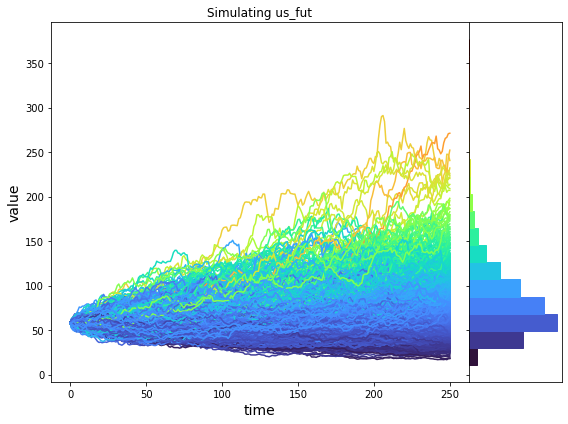

In [13]:
fancy_plot(prices_simulation_us, n = prices_simulation_us.shape[0], time_steps= prices_simulation_us.shape[1] - 1, display = 1000,
                title = f'Simulating {serie}', savefig= True, figdir= 'Figures/simulation_process_us.pdf')

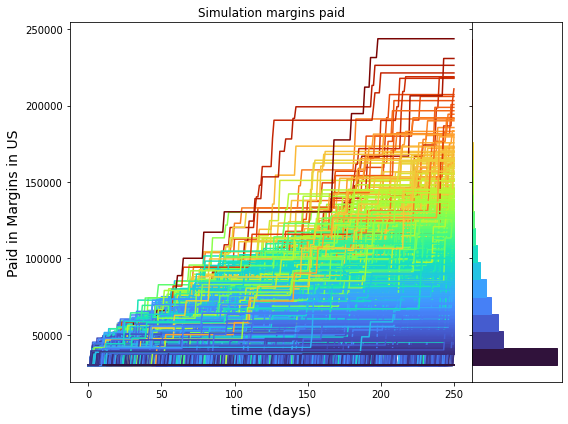

In [14]:
fancy_plot(tot_paid_us, n = tot_paid_us.shape[0], time_steps=tot_paid_us.shape[1] - 1, display = tot_paid_us.shape[0], xlabel = 'time (days)',
                 ylabel = 'Paid in Margins in US', savefig= True, figdir= 'Figures/simulation_margins_us.pdf', title = 'Simulation margins paid')

In [42]:
data_garch_simulation_us = pd.DataFrame([prices_simulation_us[:,-1],tot_paid_us[:,-1]]).transpose()
data_garch_simulation_us = data_garch_simulation_us.rename(columns = {0: 'electricity_price', 1:'margins'})

stats_simulation_us = data_garch_simulation_us.agg([ "mean","std", "min", "max", "median", "skew"]).transpose()
print(stats_simulation_us.apply(lambda x: np.round(x,2)).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &      mean &       std &       min &        max &    median &  skew \\
\midrule
electricity\_price &     84.74 &     36.53 &     16.14 &     319.78 &     77.69 &  1.21 \\
margins           &  54927.04 &  24397.87 &  30000.00 &  241130.95 &  47289.52 &  1.69 \\
\bottomrule
\end{tabular}



In [43]:
stats_simulation_us

,mean,std,min,max,median,skew
electricity_price,84.738154,36.528943,16.139714,319.783774,77.694342,1.208386
margins,54927.036736,24397.872723,30000.000000,241130.950724,47289.521093,1.691281


In [44]:
all_stats = pd.concat([stats_simulation_eu.transpose().rename(columns = {'electricity_price': 'electricity_price_eu', 'margins': 'margins_eu'}),
                       stats_simulation_us.transpose().rename(columns = {'electricity_price': 'electricity_price_us', 'margins': 'margins_us'})],
                      axis = 1)

In [45]:
print(all_stats.apply(lambda x: np.round(x,2)).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  electricity\_price\_eu &   margins\_eu &  electricity\_price\_us &  margins\_us \\
\midrule
mean   &                279.18 &    240594.03 &                 84.74 &    54927.04 \\
std    &                542.96 &    448368.60 &                 36.53 &    24397.87 \\
min    &                  0.53 &     30000.00 &                 16.14 &    30000.00 \\
max    &              14222.63 &  10597467.57 &                319.78 &   241130.95 \\
median &                124.30 &    105630.07 &                 77.69 &    47289.52 \\
skew   &                  7.66 &         7.45 &                  1.21 &        1.69 \\
\bottomrule
\end{tabular}



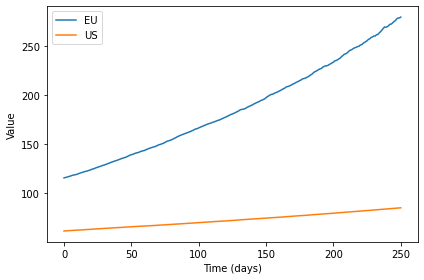

In [47]:
plt.plot(prices_simulation_eu.mean(axis = 0), label = 'EU')
plt.plot(prices_simulation_us.mean(axis = 0),label = 'US')
plt.xlabel('Time (days)')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.savefig('Figures/avg_price_simulation.pdf')
plt.show()

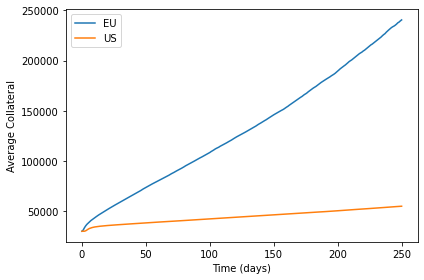

In [48]:
plt.plot(tot_paid_eu.mean(axis = 0), label = 'EU')
plt.plot(tot_paid_us.mean(axis = 0),label = 'US')
plt.xlabel('Time (days)')
plt.ylabel('Average Collateral')
plt.legend()
plt.tight_layout()
plt.savefig('Figures/avg_margin_paid_simulation.pdf')
plt.show()

In [ ]:
plt.plot(prices_simulation.mean(axis = 0), label = 'EU')
plt.plot(prices_simulation_us.mean(axis = 0),label = 'US')
plt.xlabel('Time (days)')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.savefig('Figures/avg_price_simulation.pdf')
plt.show()

In [166]:
print(0.2085 / (1 - (0.2108 + 0.7479)))
print(0.3241 / (1 - (0.0548 + 0.8713)))

5.048426150121065
4.385656292286869


#### Simulating the non squeeze period

In [104]:
serie = 'eex_qt'
M = 10000
N = 250
crisis_idx = 410


u = results[serie][1]
h = results[serie][2]

phi0 = results[serie][0][0]
phi = results[serie][0][1]


random_shocks = np.random.randint(len(u) - crisis_idx, size=(M, N)) ## Shocks between 0 and 410
random_shocks = u[random_shocks]

simulation_eu = np.zeros([M,N + 1])
simulation_eu[:,0] = np.log(data_garch[serie][1 + crisis_idx] / data_garch[serie][crisis_idx]) * 100 ## Starting crisis

for step in range(1,N+1):
    
    simulation_eu[:,step] = phi0 + np.inner(phi,simulation_eu[:,step - 1].reshape((M,1))) + random_shocks[:, step - 1]
    

prices_simulation_eu = np.zeros([M,N + 1])
prices_simulation_eu[:,0] = data_garch[serie].values[crisis_idx] # first price 

for step in range(1,N+1):
    prices_simulation_eu[:,step] = prices_simulation_eu[:,step - 1] * np.exp(simulation_eu[:,step] / 100) 

In [235]:
position = 'short' ## short means selling electricity.

M0        = 30000
M         = np.empty_like(prices_simulation_eu) 
M[:,0]    = 30000
T         = 22500
num_hours = 730
V0        = prices_simulation_eu[0,0] * num_hours * np.ones(prices_simulation_eu.shape[0])

paid_eu = np.zeros_like(prices_simulation_eu)
paid_eu[:,0] = M0

for idx, prices in enumerate(prices_simulation_eu.transpose()):
    if idx == 0:
        continue
        
    V = prices * num_hours
    
    if position == 'long':
        M[:, idx] = M[:,idx-1] + (V - V0)
        
    if position == 'short':
        M[:, idx] = M[:,idx-1] - (V - V0)
    
    condition              = M[:,idx] < T
    paid_eu[:,idx][condition] = M0 - M[:,idx][condition]
    M[:,idx][condition]    = M0
    
    if position == 'long':
        V0 = V0 - paid_eu[:,idx]
        
    if position == 'short':
        V0 = V0 + paid_eu[:,idx]

tot_paid_eu = np.cumsum(paid_eu, axis=1)

NameError: name 'prices_simulation_eu' is not defined

In [106]:
data_garch_simulations = pd.DataFrame([prices_simulation_eu[:,-1],tot_paid_eu[:,-1]]).transpose()
data_garch_simulations = data_garch_simulations.rename(columns = {0: 'electricity_price', 1:'margins'})

stats_simulation_eu = data_garch_simulations.agg([ "mean","std", "min", "max", "median", "skew"]).transpose()
print(stats_simulation_eu.transpose().apply(lambda x: np.round(x,2)).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  electricity\_price &     margins \\
\midrule
mean   &             206.58 &   118554.76 \\
std    &             141.65 &   103874.72 \\
min    &              25.42 &    30000.00 \\
max    &            1837.13 &  1353974.52 \\
median &             170.19 &    88397.82 \\
skew   &               2.68 &        2.90 \\
\bottomrule
\end{tabular}



#### Simulating with the "real" margin

In [264]:
def sigma_formula(rs, lam):
    weights = np.array([lam ** i for i in range(1,len(rs)+ 1)])
    
    S =  (lam - (lam ** (len(rs)+1)))/(1 - lam)
    
    sigma_2 = (np.inner(( rs ** 2) , weights))/S
    
    return np.sqrt(sigma_2)

def risk_multiplier(rs, sigs, alpha = 0.95):
    q = np.quantile(rs / sigs, alpha)
    Q = np.quantile(rs / sigs, 1  - alpha)
    
    return 0.5 * (np.abs(q) + np.abs(Q))


lam = 0.99
ecc_window = 255
N = 250
M = 1000
crisis_idx = 410
serie = 'eex_qt'

M0        = 30000
T         = 22500
num_hours = 730
V0        = data_garch[serie].values[-1] * num_hours
l = np.sqrt(30)

u    = results[serie][1]
h    = results[serie][2]
phi0 = results[serie][0][0]
phi  = results[serie][0][1]
df   = results[serie][0][-1]

returns = np.zeros([M, N + 2 * ecc_window])
prices_eu  = np.zeros([M, N + 2 * ecc_window])
sigmas  = np.zeros([M, N + 2 * ecc_window])
margins = np.zeros([M, N + 1])

margins[:,0] = M0

first_returns = np.log(data_garch[serie]).diff().values[-(ecc_window * 2):]
first_prices_eu  = data_garch[serie][-(ecc_window * 2 ):]

for i in range(M):
    returns[i,:2 * ecc_window] = first_returns
    prices_eu[i ,:2 * ecc_window] = first_prices_eu
    
    for time in range(ecc_window):
        sigmas[i ,ecc_window + time] = sigma_formula(returns[i, time : ecc_window + time ], lam)
        

returns = returns[:, ecc_window:]
prices_eu  = prices_eu[: , ecc_window:]
sigmas  = sigmas[: , ecc_window:]       
     
    
random_shocks = np.random.randint(len(u) - crisis_idx, size=(M, N)) + crisis_idx
random_shocks = u[random_shocks]

simulation_eu = np.zeros([M,N + 1])
simulation_eu[:,0] = np.log(data_garch[serie][-1] / data_garch[serie][-2]) * 100

Rs = []
Pts = []

for step in range(1,N+1):
    
    simulation_eu[:,step] = (phi0 + np.inner(phi,simulation_eu[:,step - 1].reshape((M,1))) + random_shocks[:, step - 1]) / 100
    returns[: ,ecc_window + step - 1] = simulation_eu[:,step]
    prices_eu[:,ecc_window + step - 1] = prices_eu[:,ecc_window + step - 2] * np.exp(simulation_eu[:,step])
    
    for m in range(M):
        sigmas[m,ecc_window + step - 1] = sigma_formula(returns[m, step - 1:ecc_window + step - 1], lam)
        
        R  = risk_multiplier(returns[m,step - 1: ecc_window + step - 1], sigmas[m,step - 1: ecc_window + step - 1])
        Pt = (num_hours * prices_eu[m,ecc_window + step - 1]) - V0
        margins[m, step] = l * Pt * sigmas[m,ecc_window + step - 1] * R
        if m == 1:
            Pts.append(Pt)
            Rs.append(R)

In [265]:
position = 'short' ## short means selling electricity.

positive_margins = margins.copy()
positive_margins[positive_margins < 0] = 0
thersholds = positive_margins.copy() * 0.75

num_hours = 730
V0        = prices_eu[:,254][0] * num_hours * np.ones(prices_eu.shape[0])

paid_eu = np.zeros_like(prices_eu[:,255:])
paid_eu[:,0] = M0

balance = np.zeros(positive_margins.shape[0])

for idx, price in enumerate(prices_eu.transpose()[255:,:]):
    if idx == 0:
        continue
        
    V = price * num_hours
    
#     if position == 'long':
#         positive_margins[:, idx] = positive_margins[:, idx] + (V - V0)
        
    if position == 'short':
        balance = positive_margins[:, idx] - (V - V0)
    
    condition                 = balance < thersholds[:, idx]
    paid_eu[:,idx][condition] = positive_margins[:,idx][condition] - balance[condition] 
    
#     if position == 'long':
#         V0 = V0 - paid_eu[:,idx]
        
    if position == 'short':
        V0 = V0 + paid_eu[:,idx]

tot_paid_eu = np.cumsum(paid_eu, axis=1)

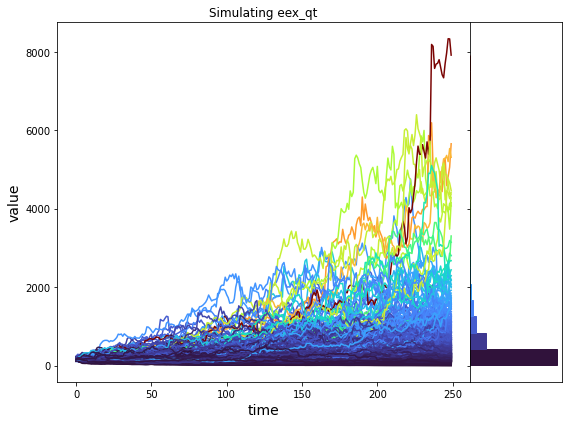

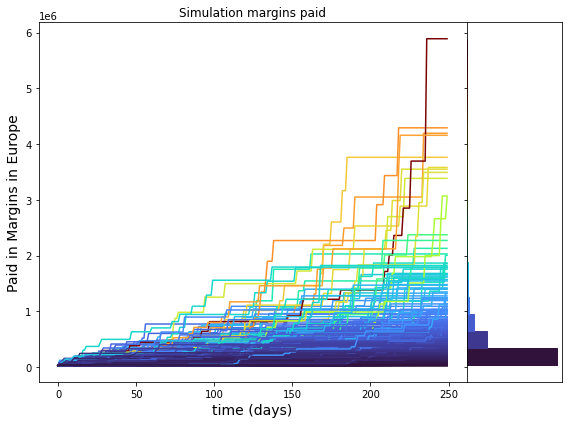

\begin{tabular}{lrr}
\toprule
{} &  electricity\_price &     margins \\
\midrule
mean   &             374.13 &   330842.04 \\
std    &             612.25 &   511587.65 \\
min    &               2.40 &    30000.00 \\
max    &            7915.74 &  5891249.22 \\
median &             185.29 &   176061.38 \\
skew   &               5.39 &        4.86 \\
\bottomrule
\end{tabular}



In [266]:
fancy_plot(prices_eu[:,255:], n = prices_eu[:,255:].shape[0], time_steps= prices_eu[:,255:].shape[1] - 1, display = 1000,
                title = f'Simulating {serie}', savefig= True, figdir= 'Figures/simulation_process_eu_squeeze.pdf')

fancy_plot(tot_paid_eu, n = tot_paid_eu.shape[0], time_steps=tot_paid_eu.shape[1] - 1, display = tot_paid_eu.shape[0], xlabel = 'time (days)',
                 ylabel = 'Paid in Margins in Europe', savefig= True, figdir= 'Figures/simulation_margins_eu_squeeze.pdf', title = 'Simulation margins paid')

data_garch_simulations = pd.DataFrame([prices_eu[:,-1],tot_paid_eu[:,-1]]).transpose()
data_garch_simulations = data_garch_simulations.rename(columns = {0: 'electricity_price', 1:'margins'})

stats = data_garch_simulations.agg([ "mean","std", "min", "max", "median", "skew"]).transpose()
print(stats.transpose().apply(lambda x: np.round(x,2)).to_latex())

In [267]:
data_garch_simulations = pd.DataFrame([prices_eu[:,-1],tot_paid_eu[:,-1]]).transpose()
data_garch_simulations = data_garch_simulations.rename(columns = {0: 'electricity_price', 1:'margins'})

stats_squeeze = data_garch_simulations.agg([ "mean","std", "median"])
stats_squeeze = stats_squeeze.rename(columns = {'electricity_price': 'electricity_price_squeeze' , 'margins':'margins_squeeze'})
print(stats.transpose().apply(lambda x: np.round(x,2)).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  electricity\_price &     margins \\
\midrule
mean   &             374.13 &   330842.04 \\
std    &             612.25 &   511587.65 \\
min    &               2.40 &    30000.00 \\
max    &            7915.74 &  5891249.22 \\
median &             185.29 &   176061.38 \\
skew   &               5.39 &        4.86 \\
\bottomrule
\end{tabular}



$\LARGE \text{The following chunck of code is for the same serie in the} $

$\LARGE \text{non-squeeze period, thus changing the initial price and the shocks}$

In [279]:
data_eex_qt_bis.sort_index().iloc[601,:][0]

35.6

In [280]:
def sigma_formula(rs, lam):
    weights = np.array([lam ** i for i in range(1,len(rs)+ 1)])
    
    S =  (lam - (lam ** (len(rs)+1)))/(1 - lam)
    
    sigma_2 = (np.inner(( rs ** 2) , weights))/S
    
    return np.sqrt(sigma_2)

def risk_multiplier(rs, sigs, alpha = 0.95):
    q = np.quantile(rs / sigs, alpha)
    Q = np.quantile(rs / sigs, 1  - alpha)
    
    return 0.5 * (np.abs(q) + np.abs(Q))

data_eex_qt_bis = data_eex_qt[crisis_idx:].copy()

lam = 0.99
ecc_window = 255
N = 250
M = 1000
crisis_idx = 410
serie = 'eex_qt'

M0        = 30000
T         = 22500
num_hours = 730
V0        = data_eex_qt_bis.sort_index().iloc[601,:][0] * num_hours
l = np.sqrt(30)

u    = results[serie][1]
h    = results[serie][2]
phi0 = results[serie][0][0]
phi  = results[serie][0][1]
df   = results[serie][0][-1]

returns = np.zeros([M, N + 2 * ecc_window])
prices_eu  = np.zeros([M, N + 2 * ecc_window])
sigmas  = np.zeros([M, N + 2 * ecc_window])
margins = np.zeros([M, N + 1])

margins[:,0] = M0

first_returns = np.log(data_eex_qt_bis.sort_index()).diff().values[-(ecc_window * 2):].flatten()
first_prices_eu  = data_eex_qt_bis.sort_index()[-(ecc_window * 2 ):]

for i in range(M):
    returns[i,:2 * ecc_window] = first_returns
    prices_eu[i ,:2 * ecc_window] = first_prices_eu.values.flatten()
    
    for time in range(ecc_window):
        sigmas[i ,ecc_window + time] = sigma_formula(returns[i, time : ecc_window + time ], lam)
        

returns = returns[:, ecc_window:]
prices_eu  = prices_eu[: , ecc_window:]
sigmas  = sigmas[: , ecc_window:]
     
    
random_shocks = np.random.randint(len(u) - crisis_idx, size=(M, N))
random_shocks = u[random_shocks]

simulation_eu = np.zeros([M,N + 1])
simulation_eu[:,0] = np.log(data_eex_qt_bis.sort_index().iloc[-1,0] / data_eex_qt_bis.sort_index().iloc[-2,0]) * 100

Rs = []
Pts = []

for step in range(1,N+1):
    
    simulation_eu[:,step] = (phi0 + np.inner(phi,simulation_eu[:,step - 1].reshape((M,1))) + random_shocks[:, step - 1]) / 100
    returns[: ,ecc_window + step - 1] = simulation_eu[:,step]
    prices_eu[:,ecc_window + step - 1] = prices_eu[:,ecc_window + step - 2] * np.exp(simulation_eu[:,step])
    
    for m in range(M):
        sigmas[m,ecc_window + step - 1] = sigma_formula(returns[m, step - 1:ecc_window + step - 1], lam)
        
        R  = risk_multiplier(returns[m,step - 1: ecc_window + step - 1], sigmas[m,step - 1: ecc_window + step - 1])
        Pt = (num_hours * prices_eu[m,ecc_window + step - 1]) - V0
        margins[m, step] = l * Pt * sigmas[m,ecc_window + step - 1] * R
        if m == 1:
            Pts.append(Pt)
            Rs.append(R)

In [281]:
position = 'short' ## short means selling electricity.

positive_margins = margins.copy()
positive_margins[positive_margins < 0] = 0
thersholds = positive_margins.copy() * 0.75

num_hours = 730
V0        = prices_eu[:,254][0] * num_hours * np.ones(prices_eu.shape[0])

paid_eu = np.zeros_like(prices_eu[:,255:])
paid_eu[:,0] = M0

balance = np.zeros(positive_margins.shape[0])

for idx, price in enumerate(prices_eu.transpose()[255:,:]):
    if idx == 0:
        continue
        
    V = price * num_hours
    
#     if position == 'long':
#         positive_margins[:, idx] = positive_margins[:, idx] + (V - V0)
        
    if position == 'short':
        balance = positive_margins[:, idx] - (V - V0)
    
    condition                 = balance < thersholds[:, idx]
    paid_eu[:,idx][condition] = positive_margins[:,idx][condition] - balance[condition] 
    
#     if position == 'long':
#         V0 = V0 - paid_eu[:,idx]
        
    if position == 'short':
        V0 = V0 + paid_eu[:,idx]

tot_paid_eu = np.cumsum(paid_eu, axis=1)

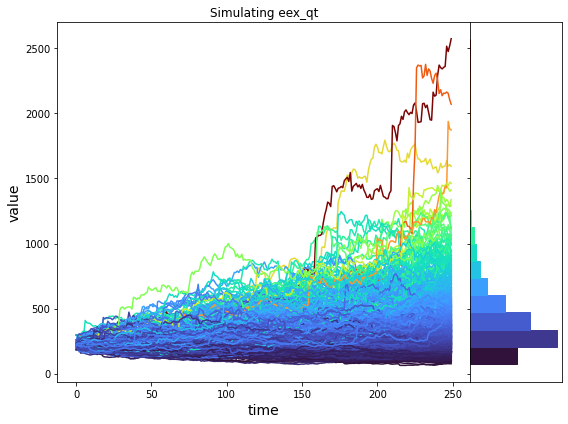

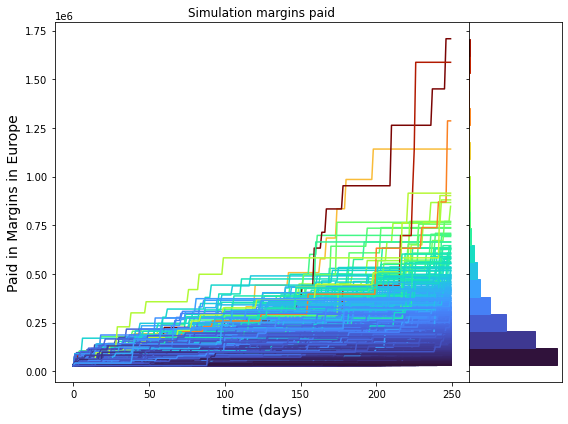

\begin{tabular}{lrr}
\toprule
{} &  electricity\_price &     margins \\
\midrule
mean   &             399.51 &   202163.89 \\
std    &             241.02 &   171653.80 \\
min    &              76.61 &    30000.00 \\
max    &            2572.87 &  1707814.80 \\
median &             339.67 &   153864.95 \\
skew   &               2.41 &        2.66 \\
\bottomrule
\end{tabular}



In [282]:
fancy_plot(prices_eu[:,255:], n = prices_eu[:,255:].shape[0], time_steps= prices_eu[:,255:].shape[1] - 1, display = 1000,
                title = f'Simulating {serie}', savefig= True, figdir= 'Figures/simulation_process_eu_non_squeeze.pdf')

fancy_plot(tot_paid_eu, n = tot_paid_eu.shape[0], time_steps=tot_paid_eu.shape[1] - 1, display = tot_paid_eu.shape[0], xlabel = 'time (days)',
                 ylabel = 'Paid in Margins in Europe', savefig= True, figdir= 'Figures/simulation_margins_eu_non_squeeze.pdf', title = 'Simulation margins paid')

data_garch_simulations = pd.DataFrame([prices_eu[:,-1],tot_paid_eu[:,-1]]).transpose()
data_garch_simulations = data_garch_simulations.rename(columns = {0: 'electricity_price', 1:'margins'})

stats = data_garch_simulations.agg([ "mean","std", "min", "max", "median", "skew"]).transpose()
print(stats.transpose().apply(lambda x: np.round(x,2)).to_latex())

In [283]:
data_garch_simulations = pd.DataFrame([prices_eu[:,-1],tot_paid_eu[:,-1]]).transpose()
data_garch_simulations = data_garch_simulations.rename(columns = {0: 'electricity_price', 1:'margins'})

stats_non_squeeze = data_garch_simulations.agg([ "mean","std", "median"])
stats_non_squeeze = stats_non_squeeze.rename(columns = {'electricity_price': 'electricity_price_non_squeeze' , 'margins':'margins_non_squeeze'})
print(stats.transpose().apply(lambda x: np.round(x,2)).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  electricity\_price &     margins \\
\midrule
mean   &             399.51 &   202163.89 \\
std    &             241.02 &   171653.80 \\
min    &              76.61 &    30000.00 \\
max    &            2572.87 &  1707814.80 \\
median &             339.67 &   153864.95 \\
skew   &               2.41 &        2.66 \\
\bottomrule
\end{tabular}



In [284]:
stats_non_squeeze

,electricity_price_non_squeeze,margins_non_squeeze
mean,399.508748,202163.890011
std,241.021062,171653.799371
median,339.665251,153864.949573


In [268]:
stats_squeeze

,electricity_price_non_squeeze,margins_non_squeeze
mean,374.126387,330842.041973
std,612.245818,511587.653556
median,185.289611,176061.377540


In [289]:
stats = pd.merge(stats_squeeze, stats_non_squeeze, left_index=True, right_index=True)

In [291]:
stats['price_diff']  = stats['electricity_price_non_squeeze_x'] - stats['electricity_price_non_squeeze_y']
stats['margin_diff'] = stats['margins_non_squeeze_x'] - stats['margins_non_squeeze_y']

In [293]:
print(stats.apply(lambda x: np.round(x,2)).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  electricity\_price\_non\_squeeze\_x &  margins\_non\_squeeze\_x &  electricity\_price\_non\_squeeze\_y &  margins\_non\_squeeze\_y &  price\_diff &  margin\_diff \\
\midrule
mean   &                           374.13 &              330842.04 &                           399.51 &              202163.89 &      -25.38 &    128678.15 \\
std    &                           612.25 &              511587.65 &                           241.02 &              171653.80 &      371.22 &    339933.85 \\
median &                           185.29 &              176061.38 &                           339.67 &              153864.95 &     -154.38 &     22196.43 \\
\bottomrule
\end{tabular}



$\LARGE \text{Now for the US time series}$ 

In [222]:
def sigma_formula(rs, lam):
    weights = np.array([lam ** i for i in range(1,len(rs)+ 1)])
    
    S =  (lam - (lam ** (len(rs)+1)))/(1 - lam)
    
    sigma_2 = (np.inner(( rs ** 2) , weights))/S
    
    return np.sqrt(sigma_2)

def risk_multiplier(rs, sigs, alpha = 0.95):
    q = np.quantile(rs / sigs, alpha)
    Q = np.quantile(rs / sigs, 1  - alpha)
    
    return 0.5 * (np.abs(q) + np.abs(Q))


lam = 0.99
ecc_window = 255
N = 250
M = 1000
crisis_idx = 0
serie = 'us_fut'

M0        = 30000
T         = 22500
num_hours = 730
V0        = data_garch[serie].values[-1] * num_hours
l = np.sqrt(30)

u    = results[serie][1]
h    = results[serie][2]
phi0 = results[serie][0][0]
phi  = results[serie][0][1]
df   = results[serie][0][-1]

returns = np.zeros([M, N + 2 * ecc_window])
prices_us  = np.zeros([M, N + 2 * ecc_window])
sigmas  = np.zeros([M, N + 2 * ecc_window])
margins = np.zeros([M, N + 1])

margins[:,0] = M0

first_returns = np.log(data_garch[serie]).diff().values[-(ecc_window * 2):]
first_prices_us  = data_garch[serie][-(ecc_window * 2 ):]

for i in range(M):
    returns[i,:2 * ecc_window] = first_returns
    prices_us[i ,:2 * ecc_window] = first_prices_us
    
    for time in range(ecc_window):
        sigmas[i ,ecc_window + time] = sigma_formula(returns[i, time : ecc_window + time ], lam)
        

returns = returns[:, ecc_window:]
prices_us  = prices_us[: , ecc_window:]
sigmas  = sigmas[: , ecc_window:]       
     
    
random_shocks = np.random.randint(len(u) - crisis_idx, size=(M, N)) + crisis_idx
random_shocks = u[random_shocks]

simulation_us = np.zeros([M,N + 1])
simulation_us[:,0] = np.log(data_garch[serie][-1] / data_garch[serie][-2]) * 100

Rs = []
Pts = []

for step in range(1,N+1):
    
    simulation_us[:,step] = (phi0 + np.inner(phi,simulation_us[:,step - 1].reshape((M,1))) + random_shocks[:, step - 1]) / 100
    returns[: ,ecc_window + step - 1] = simulation_us[:,step]
    prices_us[:,ecc_window + step - 1] = prices_us[:,ecc_window + step - 2] * np.exp(simulation_us[:,step])
    
    for m in range(M):
        sigmas[m,ecc_window + step - 1] = sigma_formula(returns[m, step - 1:ecc_window + step - 1], lam)
        
        R  = risk_multiplier(returns[m,step - 1: ecc_window + step - 1], sigmas[m,step - 1: ecc_window + step - 1])
        Pt = (num_hours * prices_us[m,ecc_window + step - 1]) - V0
        margins[m, step] = l * Pt * sigmas[m,ecc_window + step - 1] * R
        if m == 1:
            Pts.append(Pt)
            Rs.append(R)

In [223]:
position = 'short' ## short means selling electricity.

positive_margins = margins.copy()
positive_margins[positive_margins < 0] = 0
thersholds = positive_margins.copy() * 0.75

num_hours = 730
V0        = prices_us[:,254][0] * num_hours * np.ones(prices_us.shape[0])

paid_us = np.zeros_like(prices_us[:,255:])
paid_us[:,0] = M0

balance = np.zeros(positive_margins.shape[0])

for idx, price in enumerate(prices_us.transpose()[255:,:]):
    if idx == 0:
        continue
        
    V = price * num_hours
    
#     if position == 'long':
#         positive_margins[:, idx] = positive_margins[:, idx] + (V - V0)
        
    if position == 'short':
        balance = positive_margins[:, idx] - (V - V0)
    
    condition                 = balance < thersholds[:, idx]
    paid_us[:,idx][condition] = positive_margins[:,idx][condition] - balance[condition] 
    
#     if position == 'long':
#         V0 = V0 - paid_us[:,idx]
        
    if position == 'short':
        V0 = V0 + paid_us[:,idx]

tot_paid_us = np.cumsum(paid_us, axis=1)

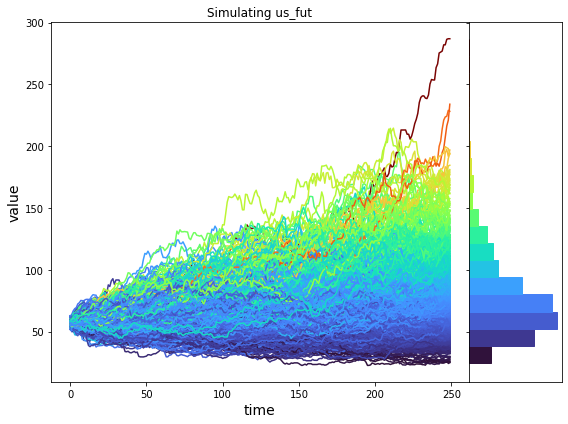

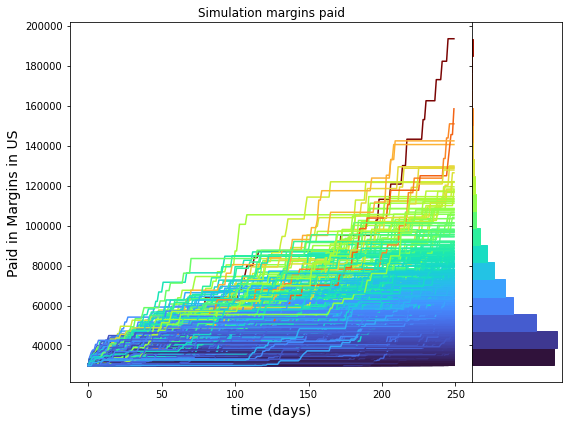

\begin{tabular}{lrr}
\toprule
{} &  electricity\_price &    margins \\
\midrule
mean   &              76.82 &   54402.09 \\
std    &              31.80 &   21037.07 \\
min    &              24.91 &   30000.00 \\
max    &             286.87 &  193476.65 \\
median &              70.12 &   48772.51 \\
skew   &               1.41 &       1.65 \\
\bottomrule
\end{tabular}



In [224]:
fancy_plot(prices_us[:,255:], n = prices_us[:,255:].shape[0], time_steps= prices_us[:,255:].shape[1] - 1, display = 1000,
                title = f'Simulating {serie}', savefig= True, figdir= 'Figures/simulation_process_us_squeeze.pdf')

fancy_plot(tot_paid_us, n = tot_paid_us.shape[0], time_steps=tot_paid_us.shape[1] - 1, display = tot_paid_us.shape[0], xlabel = 'time (days)',
                 ylabel = 'Paid in Margins in US', savefig= True, figdir= 'Figures/simulation_margins_us_squeeze.pdf', title = 'Simulation margins paid')

data_garch_simulations = pd.DataFrame([prices_us[:,-1],tot_paid_us[:,-1]]).transpose()
data_garch_simulations = data_garch_simulations.rename(columns = {0: 'electricity_price', 1:'margins'})

stats = data_garch_simulations.agg([ "mean","std", "min", "max", "median", "skew"]).transpose()
print(stats.transpose().apply(lambda x: np.round(x,2)).to_latex())

$\LARGE \text{Means plots}$

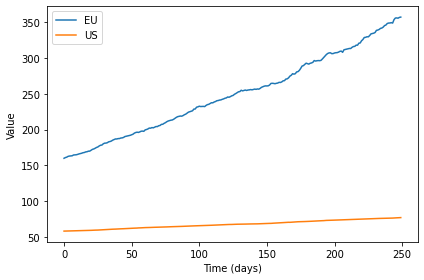

In [225]:
plt.plot(prices_eu.mean(axis = 0)[255:], label = 'EU')
plt.plot(prices_us.mean(axis = 0)[255:],label = 'US')
plt.xlabel('Time (days)')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.savefig('Figures/avg_price_simulation.pdf')
plt.show()

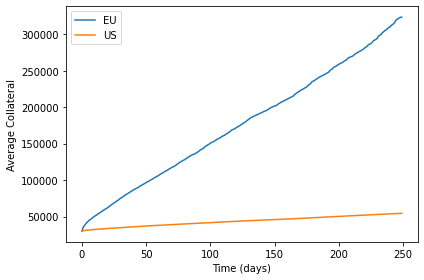

In [226]:
plt.plot(tot_paid_eu.mean(axis = 0), label = 'EU')
plt.plot(tot_paid_us.mean(axis = 0),label = 'US')
plt.xlabel('Time (days)')
plt.ylabel('Average Collateral')
plt.legend()
plt.tight_layout()
plt.savefig('Figures/avg_margin_paid_simulation.pdf')
plt.show()

### Margins in the original time_series

In [200]:
def sigma_formula(rs, lam):
    weights = np.array([lam ** i for i in range(1,len(rs)+ 1)])
    
    S =  (lam - (lam ** (len(rs)+1)))/(1 - lam)
    
    sigma_2 = (np.inner((rs ** 2) , weights))/S
    
    return np.sqrt(sigma_2)

def risk_multiplier(rs, sigs, alpha = 0.95):
    q = np.quantile(rs / sigs, alpha)
    Q = np.quantile(rs / sigs, 1  - alpha)
    
    return 0.5 * (np.abs(q) + np.abs(Q))


################### data_eex_qt case ###################

serie = 'eex_qt'

lam = 0.99
ecc_window = 255
N = 250
M = 10
crisis_idx = 410


M0        = 30000
T         = 22500
num_hours = 730
# V0        = data_eex_qt.sort_index().values[ecc_window][0] * num_hours #########
l = np.sqrt(30)

u    = results[serie][1]
h    = results[serie][2]
phi0 = results[serie][0][0]
phi  = results[serie][0][1]
df   = results[serie][0][-1]

returns = np.log(data_eex_qt.sort_index()).diff().values[1:].flatten() ##########
prices  = data_eex_qt.sort_index().values[1:].flatten()                       ##########
sigmas  = np.zeros(len(prices) - ecc_window)
margins = np.zeros(len(prices) - 2 * ecc_window - 1)


for time in range(len(prices) - ecc_window):
    sigmas[time] = sigma_formula(returns[time : ecc_window + time ], lam)
        

returns = returns[ecc_window:]
prices  = prices[ecc_window:]      
    

Rs = []
Pts = []

for time in range(len(prices) - ecc_window - 1):
    
    R  = risk_multiplier(returns[time + 1: ecc_window + time + 1], sigmas[time: ecc_window + time])
#     Pt = (num_hours * prices[time]) - V0
    Pt = (num_hours * prices[time]) ## Settlement price
    
    margins[time] = l * Pt * sigmas[time + 1] * R
    
    Rs.append(R)
    Pts.append(Pt)

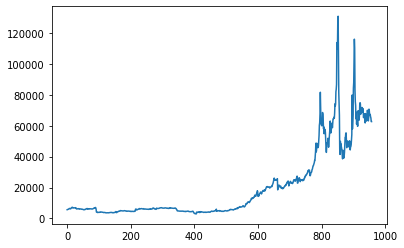

In [28]:
plt.plot(margins)
plt.show()

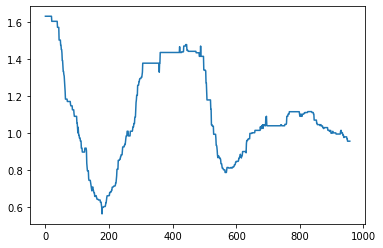

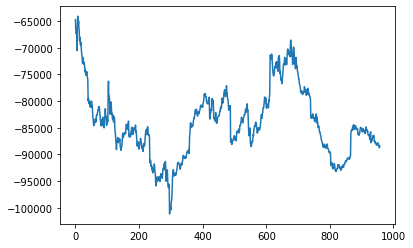

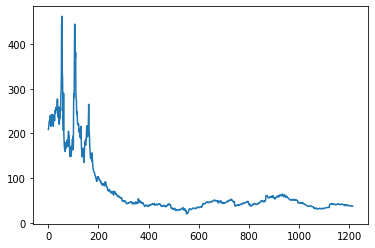

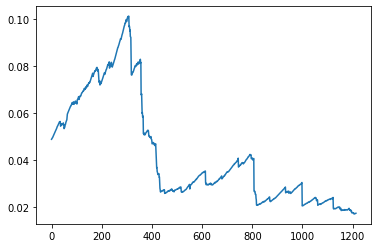

In [88]:
plt.plot(Rs)
plt.show()
plt.plot(Pts)
plt.show()
plt.plot(prices)
plt.show()
plt.plot(sigmas)
plt.show()

In [50]:
df = pd.merge(pd.DataFrame(data_garch['eex_qt']), df_margins, left_index=True, right_index=True).iloc[1:,:]

In [51]:
df

,eex_qt,Margins
2020-01-03,40.943316,6822.741867
2020-01-06,40.294676,5941.663741
2020-01-07,40.212000,4172.930523
2020-01-08,40.056666,4104.097348
2020-01-09,40.218708,4125.206668
...,...,...
2023-01-30,150.884937,45782.262304
2023-01-31,159.711372,48415.114919
2023-02-01,163.609310,47955.435240
2023-02-02,158.287722,50152.947497


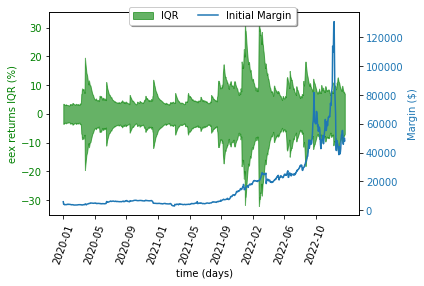

In [218]:
date_f = pd.to_datetime(pd.DataFrame(data_garch.index.values,columns=['col1']).col1).dt.to_period('m')

index = data_eex_qt.sort_index().index.values[255 + 255 + 2:]
df_margins = pd.DataFrame(margins, columns = ['Margins'])
df_margins = df_margins.set_index(index)
df_margins = pd.merge(pd.DataFrame(data_garch['eex_qt']), df_margins, left_index=True, right_index=True).iloc[1:,:]

u = results[serie][1]
h = results[serie][2]
df = results[serie][0][-1]
x = range(len(h))
# plt.figure(figsize=(10,6))
# if serie == 'us_fut':
#     plt.xticks(x, date_f[1+500:], rotation = 70)
# else:
#     plt.xticks(x, date_f[1:], rotation = 70)
# plt.locator_params(axis='x', nbins=9)

fig, ax1 = plt.subplots()
plt.xticks(x, date_f[1:], rotation = 70)
plt.locator_params(axis='x', nbins=9)

top = t.ppf(0.95, df = df, scale = np.sqrt(h) )
bot = t.ppf(0.05, df = df, scale = np.sqrt(h) )

color = 'green'
ax1.set_xlabel('time (days)')
ax1.set_ylabel('eex returns IQR (%)', color=color)
ax1.fill_between(x, top, bot, where= top >= bot, color='green', interpolate=True, alpha = 0.6, label = 'IQR')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Margin ($)', color=color)  # we already handled the x-label with ax1
ax2.plot(x, df_margins['Margins'].values, color=color, label = 'Initial Margin')
ax2.tick_params(axis='y', labelcolor=color)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=3, fancybox=True, shadow=True)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('Figures/risk_and_margin.pdf')
plt.show()



# plt.plot(x, np.sqrt(h) * eps_vol(df))



# plt.title(serie)
# plt.fill_between(x, top, bot, where= top >= bot, color='green', interpolate=True, alpha = 0.6, label = 'IQR')
# #     plt.axvline(x = 595, color = 'orange', linestyle="--", label = 'Covid')
# if serie != 'us_fut':
#     plt.axvline(x = 410, color = 'red', linestyle="--", label = 'Gas Crisis')
# plt.axhline(color = 'black')
# plt.ylim(-20,20)
# plt.legend()
# plt.show()

In [38]:
index = data_eex_qt.sort_index().index.values[255 + 255 + 2:]
df_margins = pd.DataFrame(margins, columns = ['Margins'])
df_margins = df_margins.set_index(index)

In [39]:
df_margins

,Margins
2019-08-23,5667.017868
2019-08-26,5772.571337
2019-08-27,5842.428825
2019-08-28,5917.857335
2019-08-29,5963.178541
...,...
2023-05-17,67050.483936
2023-05-18,65780.912536
2023-05-19,65014.881198
2023-05-22,62695.670234


,eex_qt,Margins
2020-01-03,40.943316,6822.741867
2020-01-06,40.294676,5941.663741
2020-01-07,40.212000,4172.930523
2020-01-08,40.056666,4104.097348
2020-01-09,40.218708,4125.206668
...,...,...
2023-01-30,150.884937,45782.262304
2023-01-31,159.711372,48415.114919
2023-02-01,163.609310,47955.435240
2023-02-02,158.287722,50152.947497


In [31]:
data_garch['eex_qt']

Datetime
2020-01-03     40.943316
2020-01-06     40.294676
2020-01-07     40.212000
2020-01-08     40.056666
2020-01-09     40.218708
                 ...    
2023-01-30    150.884937
2023-01-31    159.711372
2023-02-01    163.609310
2023-02-02    158.287722
2023-02-03    158.647764
Name: eex_qt, Length: 769, dtype: float64

,Margins
2019-08-23,5667.017868
2019-08-26,5772.571337
2019-08-27,5842.428825
2019-08-28,5917.857335
2019-08-29,5963.178541
...,...
2023-05-17,67050.483936
2023-05-18,65780.912536
2023-05-19,65014.881198
2023-05-22,62695.670234


In [79]:
ecc_window + time + 1

514

In [78]:
len(returns)

513

In [76]:
time

258

In [74]:
len(returns[time + 1: ecc_window + time + 1])a

255

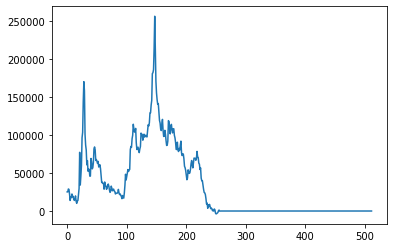

In [77]:
plt.plot(margins)

Maximum likelihood estimates:
0.2349 [-0.3939] 0.3241 [0.0548] [0.8713] 3.1187



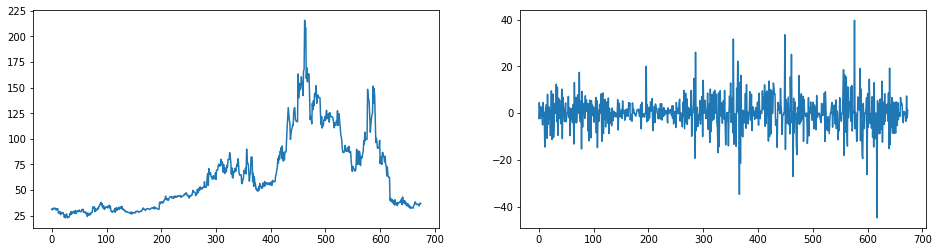

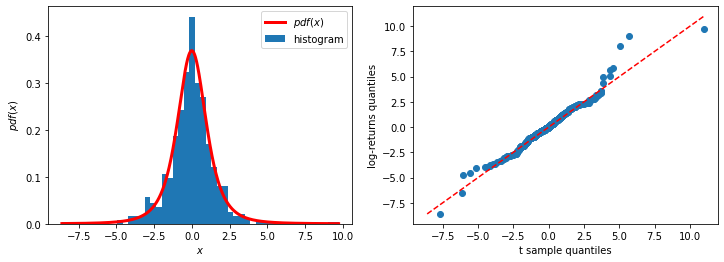

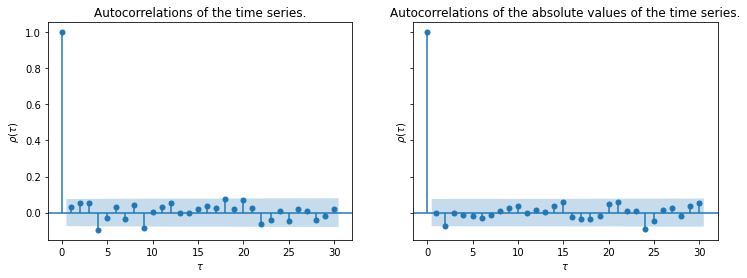

In [165]:
prices = data['Index1'].values[700:]

phi_0, phi= 0.2, [0.1]
theta = []
kappa = 0.1
alpha = [0.05]
beta = [0.90]
p = len(phi)
q = len(theta)
r = len(alpha) 
s = len(beta)
delay = max(p, q, r, s)
nu = 5

params, u, h = arma_garch_t_noise(phi_0, phi, theta, kappa, alpha, beta, nu)

In [32]:
t.ppf(0.95, df = 1.9)

3.0275397493595047

In [36]:
norm.ppf(0.975, scale = 2)

3.919927969080108

In [39]:
results['Index1'][0][-1]

2.271764650813263

In [50]:
u = results['Index1'][1]
h = results['Index1'][2]

In [85]:
date_f[2650]

Period('2022-03', 'M')